<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 0 - Introducción a Redes Neuronales </H3>
<div align='center'>
###  Felipe González - 201273534-3 
### Ignacio Tampe - 201573514-k 
</div>
<hr style="height:2px;border:none"/>

## Temas

Este documento abarca los siguientes temas:

* NNs por dentro: *back-propagation from scratch*.
* Principales hiperparámetros de *back propagation*
* Introducción a keras
* Verificación numérica de las derivadas implementadas.

## 0. Descripción del problema

En esta tarea se implementará una red neuronal desde cero. La red será utilizada en un problema de clasificación. El dataset que se utilizará se denomina: *iris*, este contiene información sobre los tamaños de los sépalos (largo y ancho) y de los pétalos (largo y ancho). Existen 3 categororías de clasificación: *Setosa*, *Versicolor* y *Virginica*

<img src="https://www.apsl.net/media/apslweb/images/iris.original.png">

## Importe de librerías necesarias para toda la tarea

In [1]:
import numpy as np
import random
import time
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import keras
%matplotlib inline

Using TensorFlow backend.


<a id="primero"></a>

## 1. Back-propagation (BP) from *Scratch*

### 1.a) Implementación de *Forward pass*, *backward pass* y rutina de entrenamiento

Para la realización de la primera parte de la tarea se implementó una red neuronal basada en SGD y con función de activación en la última capa: softmax. La estructura de la red creada es bastante flexible, por lo que se puede modificar **la cantidad de capas que la componen, la cantidad de neuronas en cada una de ellas y las funciones de activación y de costo presentes. **

Así se crearon las clases: RedNeuronal, CapaNeuronal y Neurona.

Para instanciar una red neuronal se debe realizar lo siguiente:
```python
nn = RedNeuronal(num_entrada, tam_capas, num_salida, act_inter, cost_func)
```
Donde los parámetros son:
>* **num_entrada**: dimensión de los vectores de entrada.
>* **tam_capas**: lista de cantidad de neuronas por cada capa interna, [32, 16], también indica la cantidad de capas internas.
>* **num_salida**: dimensión de los vectores de salida.
>* **act_inter**: función de activación de capas internas: "sigmoid" / "relu" / "arctan" / "softmax".
>* **cost_func**: función de costo: "crossentropy" / "mse".

La implementación que incluye *Forward pass*, *Backward pass* y rutina de entretamiento se encuentra a continuación.

Tanto *Forward pass* y *Backward pass* están implementados dentro del método correspondiente a la rutina de entrenamiento.

In [2]:
class RedNeuronal:
    
    # num_entrada: dimension de los vectores de entrada, en iris: 4
    # tam_capas: lista de cantidad de neuronas por cada capa interna, en iris: [32, 16]
    # num_salida: dimension de los vectores de salida, en iris: 3
    # act_inter: función de activación de capas internas: "sigmoid" / "relu" / "arctan" / "softmax"
    # cost_func: función de costo: "crossentropy" / "mse" 
    def __init__(self, num_entrada, tam_capas, num_salida, act_inter, cost_func):
        self.num_entrada = num_entrada
        self.tam_capas = tam_capas
        self.num_salida = num_salida
        self.capas = []
        self.log = dict()
        # iniciar todas las capas inicial - ocultas - final
        self.capas.append(CapaNeuronal(num_entrada, act_inter))
        for i in range(len(tam_capas)):
            self.capas.append(CapaNeuronal(tam_capas[i], act_inter, self.capas[i].tam_capa))
        self.capas.append(CapaNeuronal(num_salida, "softmax", self.capas[len(self.capas)-1].tam_capa))
        self.cant_capas = len(self.capas)
        if cost_func == "crossentropy":
            self.cost = self.crossentropy
            self.cost_derivative = self.crossentropy_derivative
        elif cost_func == "mse":
            self.cost = self.mse
            self.cost_derivative = self.mse_derivative
        print("Red Neuronal creada")
        print("\tCapas:", num_entrada, tam_capas, num_salida)
        print("\tActivación interna:", act_inter)
        print("\tFunción de costo:", cost_func)

    def crossentropy(self, prediccion, esperado, epsilon=1e-12): #El epsilon evita log(0)
        prediccion = np.clip(prediccion, epsilon, 1. - epsilon)
        N = prediccion.shape[0]
        ce = -np.sum(np.sum(esperado*np.log(prediccion+epsilon)))/N
        return ce
    
    def crossentropy_derivative(self, prediccion, esperado, squash_prime, vector_z):
        return prediccion-esperado

    def mse(self, prediccion, esperado):
        return 0.5*np.dot(prediccion-esperado, prediccion-esperado)
    
    def mse_derivative(self, prediccion, esperado, squash_prime, vector_z):
        return (prediccion-esperado) * squash_prime(vector_z)
    
    # train(entrada, salida, ciclos, tasa):
    # entrada: lista de datos de entrada.
    # salida: lista de vectores de salida tipo onehot.
    # ciclos: cantidad de epochs.
    # tasa: tasa de aprendizaje .
    # verbose: Booleano que indica progreso por epoch o solo el final (impresión o no de resultados intermedios).
    # momentum: agrega la posibilidad de entrenar con momentum, recibe el valor de éste.
    def train(self, entrada, salida, ciclos, tasa, verbose = False, momentum = None):
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        loss = []
        accuracy = []
        tiempo = []
        print("Comienza entrenamiento de red", end=" ")
        if momentum:
            print("con momentum", momentum)
        else:
            print()
        for ciclo in range(ciclos):
            # Comienza 1 epoch
            random.shuffle(resultList)
            errores = []
            acertados = 0
            primera_iter = True
            lista_delta_pesos = list(np.zeros(self.cant_capas))
            start = time.time()
            for input_v, output in resultList:
                #Poblar capa inicial
                self.capas[0].set_capa(input_v, input_v) 
                
                # Feed forward 
                for j in range(1, len(self.capas)):
                    self.capas[j].feed_forward(self.capas[j-1])
                
                # evaluar error final (delta función costo)
                prediccion = self.capas[last].get_activaciones()
                error_epoch = self.cost(self.capas[last].get_activaciones(), output)
                errores.append(error_epoch)
                
                if (np.argmax(prediccion) == np.argmax(output)):
                    acertados += 1
                
                #Backward pass capa final
                delta = self.cost_derivative(prediccion, np.transpose(output), self.capas[last].squash_derivative, self.capas[last].get_vector_z())
                
                self.capas[last].actualizar_bias(delta, tasa)
                
                delta_peso = np.outer(self.capas[last-1].get_activaciones(), delta)
                
                if momentum:
                    if primera_iter:
                        self.capas[last].actualizar_pesos(delta_peso, tasa)
                    else:
                        self.capas[last].actualizar_pesos_momentum(delta_peso, tasa, momentum, lista_delta_pesos[last])
                    lista_delta_pesos[last] = tasa*delta_peso
                else:
                    self.capas[last].actualizar_pesos(delta_peso, tasa)
                #Backward pass general
                for l in range(2, self.cant_capas):
                    z = self.capas[-l].get_vector_z()
                    act_prime = self.capas[-l].squash_derivative(z)
                    delta = np.dot(self.capas[-l+1].get_pesos(), delta.transpose()) * act_prime
                    delta_peso = np.outer(self.capas[-l-1].get_activaciones(),delta)
                    
                    self.capas[-l].actualizar_bias(delta, tasa)
                    if momentum:
                        if primera_iter:
                            self.capas[-l].actualizar_pesos(delta_peso, tasa)
                        else:
                            self.capas[-l].actualizar_pesos_momentum(delta_peso, tasa, momentum, lista_delta_pesos[-l])
                        #Actualizacion de lista de pesos
                        lista_delta_pesos[-l] = np.outer(self.capas[-l-1].get_activaciones(), delta)
                    else:
                        self.capas[-l].actualizar_pesos(delta_peso, tasa)
                        
                primera_iter = True
            loss.append(np.mean(errores))
            accuracy.append(acertados/len(resultList))
            tiempo.append(time.time()-start)
            primera_ter = False
            if verbose:
                print("\tError del epoch "+str(ciclo)+": loss", str(np.round(np.mean(errores),5)),"- acc", acertados/len(resultList))
        print("Resultado de training set de", ciclos,"epochs: loss", np.mean(errores),"- acc:", acertados/len(resultList))
        self.log['loss'] = loss
        self.log['accuracy'] = accuracy
        self.log['tiempo'] = tiempo

    # test(entrada, salida):
    # entrada: lista de datos de entrada de test.
    # salida: Lista de datos esperados de test, en formato onehot vector.
    # retorna listas de predicciones y valores esperados.
    def test(self, entrada, salida):
        # repetir para todas 
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        errores = []
        acertados = 0
        lista_pred = []
        lista_res = []
        for input_v, output in resultList:
            self.capas[0].set_capa(input_v, input_v) #Poblar capa inicial
            # Feed forward 
            for j in range(1, len(self.capas)):
                self.capas[j].feed_forward(self.capas[j-1])

            
            prediccion = self.capas[last].get_activaciones()
            
            if (np.argmax(prediccion) == np.argmax(output)):
                    acertados += 1
            lista_pred.append(np.argmax(prediccion))
            lista_res.append(np.argmax(output))
            # evaluar error final (delta función costo)
            error_epoch = self.cost(prediccion, output)
            errores.append(error_epoch)
        
        print("Error del test: loss", str(np.round(np.mean(errores),5)),"- acc", acertados/len(resultList))
        return lista_pred, lista_res
    
    # predict(entrada, categorias):
    # entrada: Vector de entrada para predecir
    # categorias: Etiquetas correspondientes a las categorias
    # retorna la etiqueta correspondiente a la predicción de la red neuronal 
    def predict(self, entrada, categorias):
        last = self.cant_capas-1
        self.capas[0].set_capa(entrada, entrada)
        
        for j in range(1, len(self.capas)):
                self.capas[j].feed_forward(self.capas[j-1])
        
        prediccion = self.capas[last].get_activaciones()
        
        return categorias[np.argmax(prediccion)]

In [3]:
class CapaNeuronal:
    def __init__(self, tam_capa, tipo, tam_anterior = 0):
        self.tam_capa = tam_capa
        self.tam_anterior = tam_anterior
        self.bias = 1
        self.neuronas = [Neurona(tam_anterior) for i in range(tam_capa)] # lista de neuronas de la capa
        if tipo == "sigmoid":
            self.squash = self.sigmoid
            self.squash_derivative = self.sigmoid_derivative
        elif tipo == "softmax":
            self.squash = self.softmax
            self.squash_derivative = self.softmax_derivative
        elif tipo == "arctan":
            self.squash = self.arctan
            self.squash_derivative = self.arctan_derivative
        elif tipo == "relu":
            self.squash = self.relu
            self.squash_derivative = self.relu_derivative
       
    def sigmoid(self, x):
        return np.array([np.where(i > 0, 1. / (1. + np.exp(-i)), np.exp(i) / (np.exp(i) + np.exp(0))) for i in x])
    
    def sigmoid_derivative(self, x):
        return np.multiply(self.sigmoid(x),(1-self.sigmoid(x)))
    
    def arctan(self, x):
        return np.arctan(x)
    
    def arctan_derivative(self, x):
        return np.power(np.cos(x),2)
        
    def relu(self, x):
        x= np.array(x)
        return np.maximum(x, 0, x)
    
    def relu_derivative(self, x):
        x = np.array(x)
        return (x > 0).astype(int)
    
    def softmax(self, x):
        X = np.clip(x,-350,350)
        x = np.exp(x-np.max(x))
        return x / np.sum(x, axis=0)
    
    def softmax_derivative(self, x):
        x = np.clip(x, -350, 350)
        res = []
        for i in x:
            res.append(np.exp(i)*(np.sum(np.exp(x), axis=0)-np.exp(i))/(np.sum(np.exp(x), axis=0)**2))
        #print(x)
        return np.array(res)
    
    def get_activaciones(self):
        return np.array([neurona.activacion for neurona in self.neuronas])
    
    def get_vector_z(self):
        return [neurona.z for neurona in self.neuronas]
    
    
    def feed_forward(self, capa_anterior):
        pre_squash = []
        activaciones = capa_anterior.get_activaciones()
        vector_z = capa_anterior.get_vector_z()
        for neurona in self.neuronas:
            pesos = neurona.pesos
            pre_squash.append(np.dot(pesos, activaciones) + neurona.bias)
        self.set_capa(self.squash(pre_squash), pre_squash)
   
    def get_pesos(self):
        return np.transpose(np.array([n.pesos for n in self.neuronas]))

    def actualizar_pesos(self, matriz, rate, momentum = 0, prev_delta_pesos = 0):
        pesos = np.transpose(np.array([n.pesos for n in self.neuronas]))
        pesos -= rate*matriz + momentum*prev_delta_pesos
        for i in range(len(self.neuronas)):
            self.neuronas[i].pesos = pesos[:,i]
    
    def actualizar_bias(self, vector_b, rate):
        biases = np.array([n.bias for n in self.neuronas])
        biases -= rate*vector_b #SE PUSO SUMA PORQUE BAJABA EL ERROR DEL EPOCH
        for i in range(len(self.neuronas)):
            self.neuronas[i].bias = biases[i]
    
    #Funcion para poblar datos de entrada a la red.
    def set_capa(self, activaciones, vector_z):
        for i in range(len(self.neuronas)):
            self.neuronas[i].set_activacion(activaciones[i], vector_z[i])
            
    def mostrar_capa(self):
        for neurona in self.neuronas:
            print(neurona, end="\t")
        print("\n-----------------------------")

        
class Neurona:
    def __init__(self, tam_capa_anterior):
        self.pesos = np.random.rand(tam_capa_anterior) # genera una lista de numeros aleatorios de tamaño "tam_capa_anterior"
        self.bias = np.random.rand()
        
    def set_activacion(self, valor_a, valor_z):
        self.activacion = valor_a
        self.z = valor_z
        
    def __str__(self):
        return "Activación: "+str(self.activacion)

Para poder probar el funcionamiento de la red neuronal se debe instanciar y llamar al método en entrenamiento de la siguiente forma:

```python
nn.train(entrada, salida, ciclos, tasa, verbose=False)
```

>* **entrada**: lista de datos de entrada.
>* **salida**: lista de vectores de salida tipo onehot.
>* **ciclos**: cantidad de epochs.
>* **tasa**: tasa de aprendizaje .
>* **verbose**: Booleano que indica progreso por epoch o solo el final. (keyword argument, Default: False)

Esta función tomará el dataset entregado y ejecutará una rutina de Feed Forward -> Cálculo de error -> Backpropagation por la cantidad de ciclos necesarias, mezclando en cada ciclo los datos de forma aleatoria para minimizar sesgo (Se aplicó SGD).

### 1.b) Predicciones utilizando feed forward

Una vez entrenada la red, se puede utilizar para realizar predicciones de la siguiente forma:
```python
categorias = ['setosa', 'versicolor', 'verginica']
for entrada in x_test:
    prediccion = nn.predict(entrada, categorias)
```
Esta función tomará una entrada e intentará realizar una predicción mediante *Feed Forward*, retornando la etiqueta correspondiente. 

La función "predict" fue implementada de la siguiente forma (se puede encontrar en la  [sección 1](#primero)):

```python
# predict(entrada, categorias):
# entrada: Vector de entrada para predecir
# categorias: Etiquetas correspondientes a las categorias
# retorna la etiqueta correspondiente a la predicción de la red neuronal 
def predict(self, entrada, categorias):
    last = self.cant_capas-1
    self.capas[0].set_capa(entrada, entrada)

    for j in range(1, len(self.capas)):
            self.capas[j].feed_forward(self.capas[j-1])

    prediccion = self.capas[last].get_activaciones()

    return categorias[np.argmax(prediccion)]
```

### 1.c) Probar la implementación en un problema de clasificación.

Para probar nuestra implementación de red neuronal se utilizó el dataset iris el cual se normalizó y se separó en un *training set* y un *testing set*.

In [4]:
#Carga y estructuración de datos
x, y = load_iris(return_X_y=True)
scaler = StandardScaler().fit(x)
x = scaler.transform(x) 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=50)
y_onehot_train = keras.utils.to_categorical(y_train)
y_onehot_test = keras.utils.to_categorical(y_test)
tags = ['setosa', 'versicolor', 'verginica']

Con los datos cargados se procede a instanciar las 4 redes neuronales a evaluar, utilizando *sigmoid* o *ReLU* como función de activación y usando *MSE* o *Cross Entropy* como función de costo:

Las funciones de activación están implementadas dentro de la clase CapaNeuronal junto con sus derivadas ([sección 1](#primero)).

Las funciones de costo están implementadas dentro de la clase RedNeuronal junto con sus derivadas ([sección 1](#primero)).

In [5]:
# Instanciar redes neuronales
nn_sm = RedNeuronal(4, [32, 16], 3, "sigmoid", "mse")
nn_sc = RedNeuronal(4, [32, 16], 3, "sigmoid", "crossentropy")
nn_rm = RedNeuronal(4, [32, 16], 3, "relu", "mse")
nn_rc = RedNeuronal(4, [32, 16], 3, "relu", "crossentropy")

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: mse
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: relu
	Función de costo: mse
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: relu
	Función de costo: crossentropy


Luego se procede a entrenar cada una de las redes con 100 *epochs* y un *learning rate* $\eta = 0.1$

Tras esto se extraen los datos del registro de entrenamiento:

In [6]:
#Entrenar la red 
nn_sm.train(x_train, y_onehot_train, 100, 0.1)
nn_sc.train(x_train, y_onehot_train, 100, 0.1)
nn_rm.train(x_train, y_onehot_train, 100, 0.1)
nn_rc.train(x_train, y_onehot_train, 100, 0.1)

loss_sm = nn_sm.log['loss']
accuracy_sm = nn_sm.log['accuracy']
tiempo_sm = nn_sm.log['tiempo']

loss_sc = nn_sc.log['loss']
accuracy_sc = nn_sc.log['accuracy']
tiempo_sc = nn_sc.log['tiempo']

loss_rm = nn_rm.log['loss']
accuracy_rm = nn_rm.log['accuracy']
tiempo_rm = nn_rm.log['tiempo']

loss_rc = nn_rc.log['loss']
accuracy_rc = nn_rc.log['accuracy']
tiempo_rc = nn_rc.log['tiempo']

Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.169158698465 - acc: 0.7
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.0568962312653 - acc: 0.96
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.67 - acc: 0.33
Comienza entrenamiento de red 


C:\Users\gonza\AppData\Local\conda\conda\envs\redesneuronales\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in subtract
C:\Users\gonza\AppData\Local\conda\conda\envs\redesneuronales\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in maximum
C:\Users\gonza\AppData\Local\conda\conda\envs\redesneuronales\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


Resultado de training set de 100 epochs: loss nan - acc: 0.33


Tras entrenar las redes, se procede a graficar la función objetivo "Loss" y la precisión de clasificación:

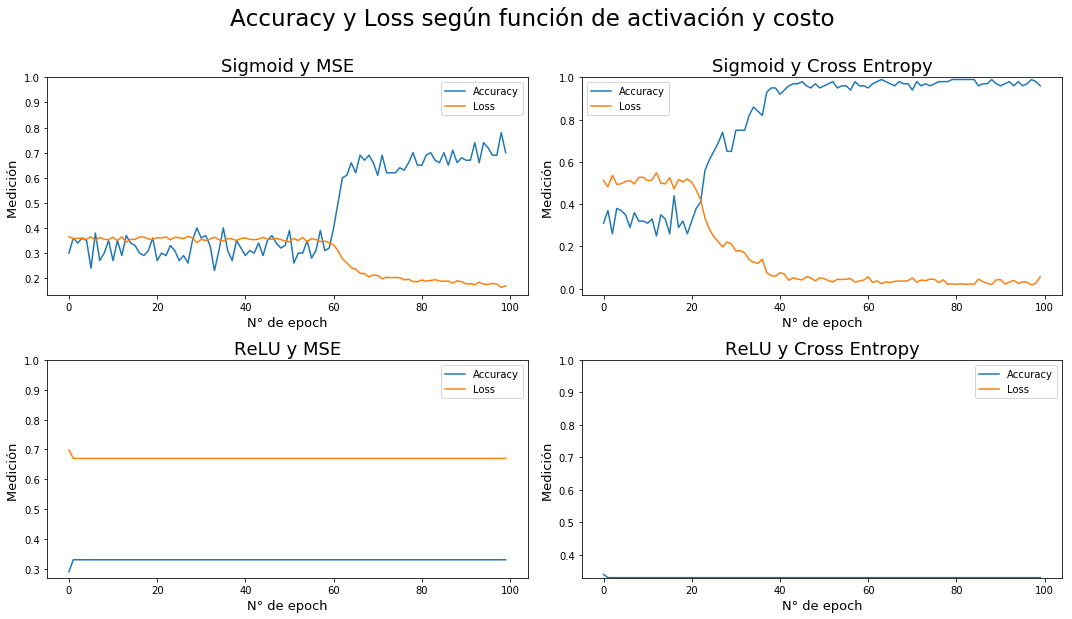

Resultados configuración: Sigmoid - MSE
Accuracy final:  70.0 %
Loss final:  0.169158698465
Tiempo total:  15.916 segundos


Resultados configuración: Sigmoid - Cross Entropy
Accuracy final:  96.0 %
Loss final:  0.0568962312653
Tiempo total:  14.928 segundos


Resultados configuración: ReLU - MSE
Accuracy final:  33.0 %
Loss final:  0.67
Tiempo total:  4.676 segundos


Resultados configuración: ReLU - Cross Entropy
Accuracy final:  33.0 %
Loss final:  0.169158698465
Tiempo total:  4.534 segundos




In [7]:
#Busqueda del maximo valor en los resultados para ajustes de graficos
x = [1,max(loss_sm),max(loss_sc),max(loss_rm),max(loss_rc)]
valor_maximo = max(x)


plt.figure(1, figsize=(15,8))
plt.suptitle("Accuracy y Loss según función de activación y costo \n \n", fontsize=23, y=1.07)
plt.subplot(221)
plt.title("Sigmoid y MSE",fontsize=18)
plt.plot(range(len(accuracy_sm)), accuracy_sm, label="Accuracy")
plt.plot(range(len(loss_sm)), loss_sm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(222)
plt.title("Sigmoid y Cross Entropy",fontsize=18)
plt.plot(range(len(accuracy_sc)), accuracy_sc, label="Accuracy")
plt.plot(range(len(loss_sc)), loss_sc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(223)
plt.title("ReLU y MSE",fontsize=18)
plt.plot(range(len(accuracy_rm)), accuracy_rm, label="Accuracy")
plt.plot(range(len(loss_rm)), loss_rm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(224)
plt.title("ReLU y Cross Entropy",fontsize=18)
plt.plot(range(len(accuracy_rc)), accuracy_rc, label="Accuracy")
plt.plot(range(len(loss_rc)), loss_rc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.tight_layout() 
plt.show()

print("Resultados configuración: Sigmoid - MSE")
print("Accuracy final: ",accuracy_sm[-1]*100,"%")
print("Loss final: ",loss_sm[-1])
print("Tiempo total: ", round(np.sum(tiempo_sm),3),"segundos")
print("\n")

print("Resultados configuración: Sigmoid - Cross Entropy")
print("Accuracy final: ",accuracy_sc[-1]*100,"%")
print("Loss final: ",loss_sc[-1])
print("Tiempo total: ", round(np.sum(tiempo_sc),3),"segundos")
print("\n")

print("Resultados configuración: ReLU - MSE")
print("Accuracy final: ",accuracy_rm[-1]*100,"%")
print("Loss final: ",loss_rm[-1])
print("Tiempo total: ", round(np.sum(tiempo_rm),3),"segundos")
print("\n")

print("Resultados configuración: ReLU - Cross Entropy")
print("Accuracy final: ",accuracy_rc[-1]*100,"%")
print("Loss final: ",loss_sm[-1])
print("Tiempo total: ", round(np.sum(tiempo_rc),3),"segundos")
print("\n")


Los resultados anteriores permiten notar que con el dataset utilizando y los parámetros entregados las configuraciones *Sigmoid-MSE* y *Sigmoid-Cross Entropy* minimizan la pérdida y maximizan la precisión (*accuracy*) a medida que aumentan el número de epochs.  La combinación  *Sigmoid - Cross Entropy* permiten alcanzar un *accuracy* del 96%, y es la combinación que entrega mejor resultado para este caso. 

Con respecto al tiempo, las combinaciones que utilizan como función de activación: *ReLU* son las más rápidas. A modo de ejemplo, la combinación de *ReLU* con *Cross Entropy* es tres veces más rápida que la combinación *Sigmoid - Cross Entropy*.

A pesar de la rapidez que entrega *ReLU*, los resultados con respecto al *accuracy* y *loss* no son los esperados. Un estudio en detalle permitió notar que la función implementada entrega resultados deficientes al incorporar dos capas ocultas. En vista de lo anterior, se realizaron estudios para analizar los resultados obtenidos de una red que utiliza ReLU a la cual se le varía el número de neuronas en su capa oculta.  La implementación y los resultados fueron los siguientes:

#### Definiciones de distintas redes con ReLU.  

Notar que se instancian 8 redes que utilizan ReLU (4 de ellas utilizan MSE y las otras 4 utilizan Cross Entrpopy). La cantidad de neuronas en su capa oculta fue distinta en cada ocasión: 16, 32, 64 y 128 neuronas respectivamente. Solo hay una capa oculta.

In [8]:
#Redes con RelU - MSE. las redes tienen distintas cantidades de neuronas en su capa oculta

nn_rm_16 = RedNeuronal(4, [16], 3, "relu", "mse")
nn_rm_32 = RedNeuronal(4, [32], 3, "relu", "mse")
nn_rm_64 = RedNeuronal(4, [64], 3, "relu", "mse")
nn_rm_128 = RedNeuronal(4, [128], 3, "relu", "mse")

#Redes con RelU - Cross Entropy. las redes tienen distintas cantidades de neuronas en su capa oculta

nn_rc_16 = RedNeuronal(4, [16], 3, "relu", "crossentropy")
nn_rc_32 = RedNeuronal(4, [32], 3, "relu", "crossentropy")
nn_rc_64 = RedNeuronal(4, [64], 3, "relu", "crossentropy")
nn_rc_128 = RedNeuronal(4, [128], 3, "relu", "crossentropy")


Red Neuronal creada
	Capas: 4 [16] 3
	Activación interna: relu
	Función de costo: mse
Red Neuronal creada
	Capas: 4 [32] 3
	Activación interna: relu
	Función de costo: mse
Red Neuronal creada
	Capas: 4 [64] 3
	Activación interna: relu
	Función de costo: mse
Red Neuronal creada
	Capas: 4 [128] 3
	Activación interna: relu
	Función de costo: mse
Red Neuronal creada
	Capas: 4 [16] 3
	Activación interna: relu
	Función de costo: crossentropy
Red Neuronal creada
	Capas: 4 [32] 3
	Activación interna: relu
	Función de costo: crossentropy
Red Neuronal creada
	Capas: 4 [64] 3
	Activación interna: relu
	Función de costo: crossentropy
Red Neuronal creada
	Capas: 4 [128] 3
	Activación interna: relu
	Función de costo: crossentropy


#### Entrenamiento de redes con ReLU

In [9]:
nn_rm_16.train(x_train, y_onehot_train, 100, 0.1)
nn_rm_32.train(x_train, y_onehot_train, 100, 0.1)
nn_rm_64.train(x_train, y_onehot_train, 100, 0.1)
nn_rm_128.train(x_train, y_onehot_train, 100, 0.1)

nn_rc_16.train(x_train, y_onehot_train, 100, 0.1)
nn_rc_32.train(x_train, y_onehot_train, 100, 0.1)
nn_rc_64.train(x_train, y_onehot_train, 100, 0.1)
nn_rc_128.train(x_train, y_onehot_train, 100, 0.1)


loss_rm_16 = nn_rm_16.log['loss']
accuracy_rm_16 = nn_rm_16.log['accuracy']
tiempo_rm_16 = nn_rm_16.log['tiempo']

loss_rm_32 = nn_rm_32.log['loss']
accuracy_rm_32 = nn_rm_32.log['accuracy']
tiempo_rm_32 = nn_rm_32.log['tiempo']

loss_rm_64 = nn_rm_64.log['loss']
accuracy_rm_64 = nn_rm_64.log['accuracy']
tiempo_rm_64 = nn_rm_64.log['tiempo']

loss_rm_128 = nn_rm_128.log['loss']
accuracy_rm_128 = nn_rm_128.log['accuracy']
tiempo_rm_128 = nn_rm_128.log['tiempo']

loss_rc_16 = nn_rc_16.log['loss']
accuracy_rc_16 = nn_rc_16.log['accuracy']
tiempo_rc_16 = nn_rc_16.log['tiempo']

loss_rc_32 = nn_rc_32.log['loss']
accuracy_rc_32 = nn_rc_32.log['accuracy']
tiempo_rc_32 = nn_rc_32.log['tiempo']

loss_rc_64 = nn_rc_64.log['loss']
accuracy_rc_64 = nn_rc_64.log['accuracy']
tiempo_rc_64 = nn_rc_64.log['tiempo']

loss_rc_128 = nn_rc_128.log['loss']
accuracy_rc_128 = nn_rc_128.log['accuracy']
tiempo_rc_128 = nn_rc_128.log['tiempo']





Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.0132692279431 - acc: 0.99
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.0121349509086 - acc: 0.99
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.0136526491349 - acc: 0.99
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.0103706533189 - acc: 0.99
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.628550391825 - acc: 0.93
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 1.88565117548 - acc: 0.79
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.808136218061 - acc: 0.91
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 1.79585826236 - acc: 0.8


### Resultados para ReLU - MSE con 1 capa oculta

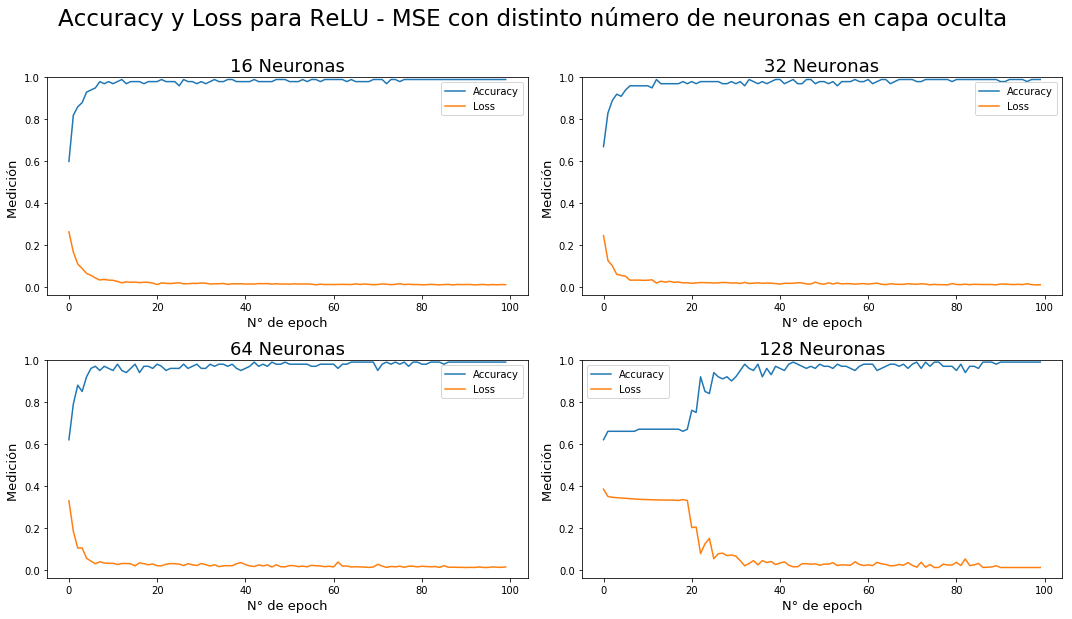

Resultados configuración: ReLU - MSE - 16 Neuronas en capa oculta
Accuracy final:  99.0 %
Loss final:  0.0132692279431
Tiempo total:  2.835 segundos


Resultados configuración: ReLU - MSE - 32 Neuronas en capa oculta
Accuracy final:  99.0 %
Loss final:  0.0121349509086
Tiempo total:  3.262 segundos


Resultados configuración: ReLU - MSE - 64 Neuronas en capa oculta
Accuracy final:  99.0 %
Loss final:  0.0136526491349
Tiempo total:  4.567 segundos


Resultados configuración: ReLU - MSE - 128 Neuronas en capa oculta
Accuracy final:  99.0 %
Loss final:  0.0103706533189
Tiempo total:  7.11 segundos




In [10]:
#Busqueda del maximo valor en los resultados para ajustes de graficos
x = [1,max(loss_rm_16),max(loss_rm_32),max(loss_rm_64),max(loss_rm_128)]
valor_maximo = max(x)


plt.figure(1, figsize=(15,8))
plt.suptitle("Accuracy y Loss para ReLU - MSE con distinto número de neuronas en capa oculta \n \n", fontsize=23, y=1.07)
plt.subplot(221)
plt.title("16 Neuronas",fontsize=18)
plt.plot(range(len(accuracy_rm_16)), accuracy_rm_16, label="Accuracy")
plt.plot(range(len(loss_rm_16)), loss_rm_16, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(222)
plt.title("32 Neuronas",fontsize=18)
plt.plot(range(len(accuracy_rm_32)), accuracy_rm_32, label="Accuracy")
plt.plot(range(len(loss_rm_32)), loss_rm_32, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(223)
plt.title("64 Neuronas",fontsize=18)
plt.plot(range(len(accuracy_rm_64)), accuracy_rm_64, label="Accuracy")
plt.plot(range(len(loss_rm_64)), loss_rm_64, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(224)
plt.title("128 Neuronas",fontsize=18)
plt.plot(range(len(accuracy_rm_128)), accuracy_rm_128, label="Accuracy")
plt.plot(range(len(loss_rm_128)), loss_rm_128, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.tight_layout() 
plt.show()

print("Resultados configuración: ReLU - MSE - 16 Neuronas en capa oculta")
print("Accuracy final: ",accuracy_rm_16[-1]*100,"%")
print("Loss final: ",loss_rm_16[-1])
print("Tiempo total: ", round(np.sum(tiempo_rm_16),3),"segundos")
print("\n")

print("Resultados configuración: ReLU - MSE - 32 Neuronas en capa oculta")
print("Accuracy final: ",accuracy_rm_32[-1]*100,"%")
print("Loss final: ",loss_rm_32[-1])
print("Tiempo total: ", round(np.sum(tiempo_rm_32),3),"segundos")
print("\n")

print("Resultados configuración: ReLU - MSE - 64 Neuronas en capa oculta")
print("Accuracy final: ",accuracy_rm_64[-1]*100,"%")
print("Loss final: ",loss_rm_64[-1])
print("Tiempo total: ", round(np.sum(tiempo_rm_64),3),"segundos")
print("\n")

print("Resultados configuración: ReLU - MSE - 128 Neuronas en capa oculta")
print("Accuracy final: ",accuracy_rm_128[-1]*100,"%")
print("Loss final: ",loss_rm_128[-1])
print("Tiempo total: ", round(np.sum(tiempo_rm_128),3),"segundos")
print("\n")


Los resultados anteriores permiten concluir que a mayor número de neuronas en la capa oculta, el tiempo total de entrenamiento aumenta. Además, para este caso, el *accuracy* final alcanzado es del 99% para todos los casos, sin importar el número de neuronas presentes en la capa oculta. Esto se debe a que el algoritmo tiende a converger bastante rápido, en efecto, en el epoch #20 ya se obtiene un *accuracy* superior al 90% en todos los casos. 

Hay que notar que para el caso del ejemplo con 128 neuronas, en ella se presenta una mayor variación del *Loss* y *accuracy* por epoch en comparación a los otros casos. De hecho, se puede ver que es el algoritmo que converge más lento. 

### Resultados para ReLU - Cross Entropy con 1 capa oculta

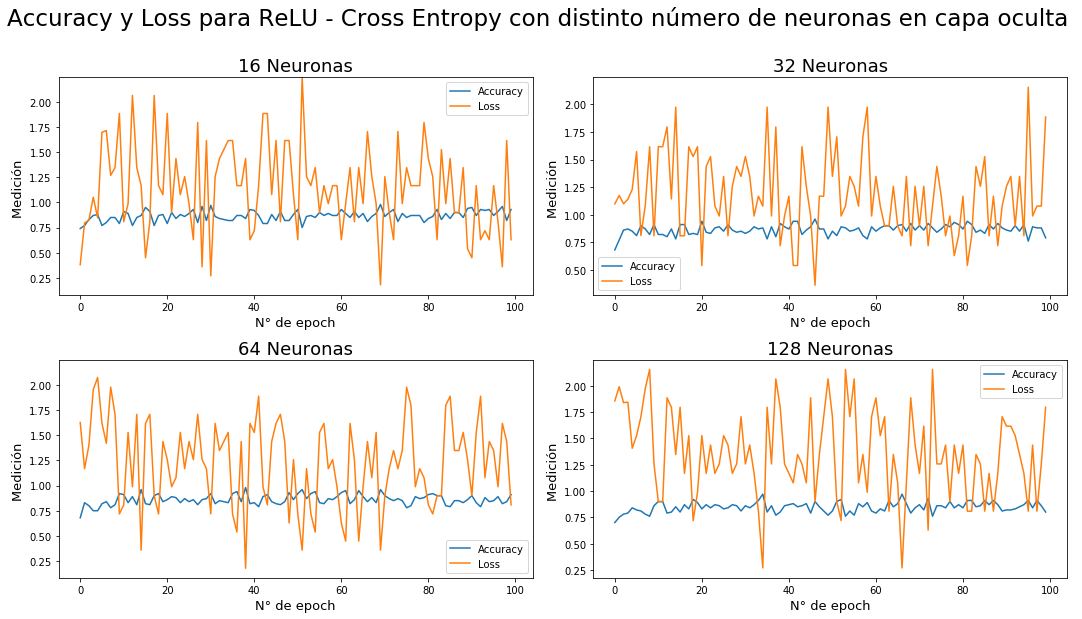

Resultados configuración: ReLU - Cross Entropy - 16 Neuronas en capa oculta
Accuracy final:  93.0 %
Loss final:  0.628550391825
Tiempo total:  2.437 segundos


Resultados configuración: ReLU - Cross Entropy - 32 Neuronas en capa oculta
Accuracy final:  79.0 %
Loss final:  1.88565117548
Tiempo total:  2.946 segundos


Resultados configuración: ReLU - Cross Entropy - 64 Neuronas en capa oculta
Accuracy final:  91.0 %
Loss final:  0.808136218061
Tiempo total:  4.373 segundos


Resultados configuración: ReLU - Cross Entropy - 128 Neuronas en capa oculta
Accuracy final:  80.0 %
Loss final:  1.79585826236
Tiempo total:  6.467 segundos




In [11]:
#Busqueda del maximo valor en los resultados para ajustes de graficos
x = [1,max(loss_rc_16),max(loss_rc_32),max(loss_rc_64),max(loss_rc_128)]
valor_maximo = max(x)


plt.figure(1, figsize=(15,8))
plt.suptitle("Accuracy y Loss para ReLU - Cross Entropy con distinto número de neuronas en capa oculta \n \n", fontsize=23, y=1.07)
plt.subplot(221)
plt.title("16 Neuronas",fontsize=18)
plt.plot(range(len(accuracy_rc_16)), accuracy_rc_16, label="Accuracy")
plt.plot(range(len(loss_rc_16)), loss_rc_16, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(222)
plt.title("32 Neuronas",fontsize=18)
plt.plot(range(len(accuracy_rc_32)), accuracy_rc_32, label="Accuracy")
plt.plot(range(len(loss_rc_32)), loss_rc_32, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(223)
plt.title("64 Neuronas",fontsize=18)
plt.plot(range(len(accuracy_rc_64)), accuracy_rc_64, label="Accuracy")
plt.plot(range(len(loss_rc_64)), loss_rc_64, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(224)
plt.title("128 Neuronas",fontsize=18)
plt.plot(range(len(accuracy_rc_128)), accuracy_rc_128, label="Accuracy")
plt.plot(range(len(loss_rc_128)), loss_rc_128, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.tight_layout() 
plt.show()

print("Resultados configuración: ReLU - Cross Entropy - 16 Neuronas en capa oculta")
print("Accuracy final: ",accuracy_rc_16[-1]*100,"%")
print("Loss final: ",loss_rc_16[-1])
print("Tiempo total: ", round(np.sum(tiempo_rc_16),3),"segundos")
print("\n")

print("Resultados configuración: ReLU - Cross Entropy - 32 Neuronas en capa oculta")
print("Accuracy final: ",accuracy_rc_32[-1]*100,"%")
print("Loss final: ",loss_rc_32[-1])
print("Tiempo total: ", round(np.sum(tiempo_rc_32),3),"segundos")
print("\n")

print("Resultados configuración: ReLU - Cross Entropy - 64 Neuronas en capa oculta")
print("Accuracy final: ",accuracy_rc_64[-1]*100,"%")
print("Loss final: ",loss_rc_64[-1])
print("Tiempo total: ", round(np.sum(tiempo_rc_64),3),"segundos")
print("\n")

print("Resultados configuración: ReLU - Cross Entropy - 128 Neuronas en capa oculta")
print("Accuracy final: ",accuracy_rc_128[-1]*100,"%")
print("Loss final: ",loss_rc_128[-1])
print("Tiempo total: ", round(np.sum(tiempo_rc_128),3),"segundos")
print("\n")


Recordar que en los gráficos anteriores el *accuracy* se marca con azul mientras que *loss* se marca con naranjo. 

Tras los resultados anteriores podemos concluir que el tiempo de entrenamiento es proporcional directamente al número de neuronas de la capa oculta.  Además, podemos notar que el número de neuronas tiene influencia en el *accuracy* y *loss* logrado en cada caso. 

Sorprendentemente, dentro de lo mostrado, los mejores resultados se obtienen con 16 neuronas dentro de la capa oculta. Por lo tanto no existe evidencia para decir que la precisión del algoritmo mejora al aumentar la cantidad de neuronas. 

También hay que notar que *Loss* varía considerablemente por epoch sin importar el número de neuronas presente en la capa oculta.


### Matriz de confusión para test con red de activación sigmoid y costo Cross-Entropy

Además de las funciones mencionadas previamente, se creó un método para hacer una rutina de testing y evaluar loss y accuracy con un dataset desconocido para la red neuronal:

```python
nn.test(entrada, salida)
```
Los parámetros de la función son:
>* entrada: lista de datos de entrada de test
>* salida: Lista de datos esperados de test, en formato onehot vector

retorna listas de resultados predichos y esperados para poder realizar un análisis de confusión.

al probar esto con una red que tiene como función de activación: *sigmoid* y función de costo: *Cross Entropy* se obtiene:

Error del test: loss 0.03937 - acc 0.96
Normalized confusion matrix
[[ 1.          0.          0.        ]
 [ 0.          0.88235294  0.11764706]
 [ 0.          0.          1.        ]]


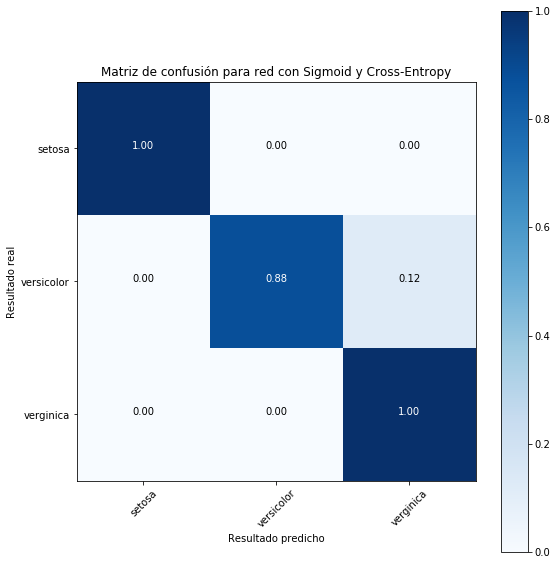

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Resultado real')
    plt.xlabel('Resultado predicho')
    
pred, real = nn_sc.test(x_test, y_onehot_test)
cnf_matrix = confusion_matrix(real, pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=tags, normalize=True,
                      title='Matriz de confusión para red con Sigmoid y Cross-Entropy')

De la matriz se desprende que solo un pequeño porcentaje del test falló, ya que la red predijo que era una planta del tipo "Verginica" cuando en realidad era de tipo "Versicolor".

Fuera de esto, el resto de las predicciones no fallaron obteniéndose un 100% de precisión en algunos casos, como se ve en la diagonal de la matriz.

### Funciónes de activación y de costo 

Se implementaron distintas funciones de activación y de costo en la [sección 1](#primero). Todas ellas se presentan de manera explícita en las siguientes lineas. 


#### Función de activación: Sigmoid

````python

    def sigmoid(self, x):
        return np.array([np.where(i > 0, 1. / (1. + np.exp(-i)), np.exp(i) / (np.exp(i) + np.exp(0))) for i in x])
    
    def sigmoid_derivative(self, x):
        return np.multiply(self.sigmoid(x),(1-self.sigmoid(x)))
        
````

#### Función de activación: ReLU
````python

    def relu(self, x):
        x= np.array(x)
        return np.maximum(x, 0, x)
    
    def relu_derivative(self, x):
        x = np.array(x)
        return (x > 0).astype(int)
 
````

#### Función de costo: Cross Entropy
````python
    def crossentropy(self, prediccion, esperado, epsilon=1e-12): #El epsilon evita log(0)
        prediccion = np.clip(prediccion, epsilon, 1. - epsilon)
        N = prediccion.shape[0]
        ce = -np.sum(np.sum(esperado*np.log(prediccion+epsilon)))/N
        return ce
    
    def crossentropy_derivative(self, prediccion, esperado, squash_prime, vector_z):
        return prediccion-esperado
````

#### Función de costo: Median Squared Error
````python
    def mse(self, prediccion, esperado):
        return 0.5*np.dot(prediccion-esperado, prediccion-esperado)
    
    def mse_derivative(self, prediccion, esperado, squash_prime, vector_z):
        return (prediccion-esperado) * squash_prime(vector_z)
````


### Red con Arcotangente

Notar que en la [sección 1](#primero) se implementó de manera adicional dentro del algoritmo la función de activación: Arcotangente. 

```python
    def arctan(self, x):
        return np.arctan(x)
    
    def arctan_derivative(self, x):
        return np.power(np.cos(x),2)
 
```

Con ella se pudo obtener los siguientes resultados:


#### Definición de red con función de activación: Arcotangente

In [13]:
# Arco tangente - MSE
nn_am = RedNeuronal(4, [16,32], 3, "arctan", "mse")
# Arco tangente - Cross Entropy
nn_ac = RedNeuronal(4, [16,32], 3, "arctan", "crossentropy")


Red Neuronal creada
	Capas: 4 [16, 32] 3
	Activación interna: arctan
	Función de costo: mse
Red Neuronal creada
	Capas: 4 [16, 32] 3
	Activación interna: arctan
	Función de costo: crossentropy


#### Entrenamiento de redes con Arcotangente

In [14]:
nn_am.train(x_train, y_onehot_train, 100, 0.1)
nn_ac.train(x_train, y_onehot_train, 100, 0.1)

loss_am = nn_am.log['loss']
accuracy_am = nn_am.log['accuracy']
tiempo_am = nn_am.log['tiempo']

loss_ac = nn_ac.log['loss']
accuracy_ac = nn_ac.log['accuracy']
tiempo_ac = nn_ac.log['tiempo']


Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.0191816894912 - acc: 0.98
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.818407193533 - acc: 0.69


#### Resultados para red con Arcotangente

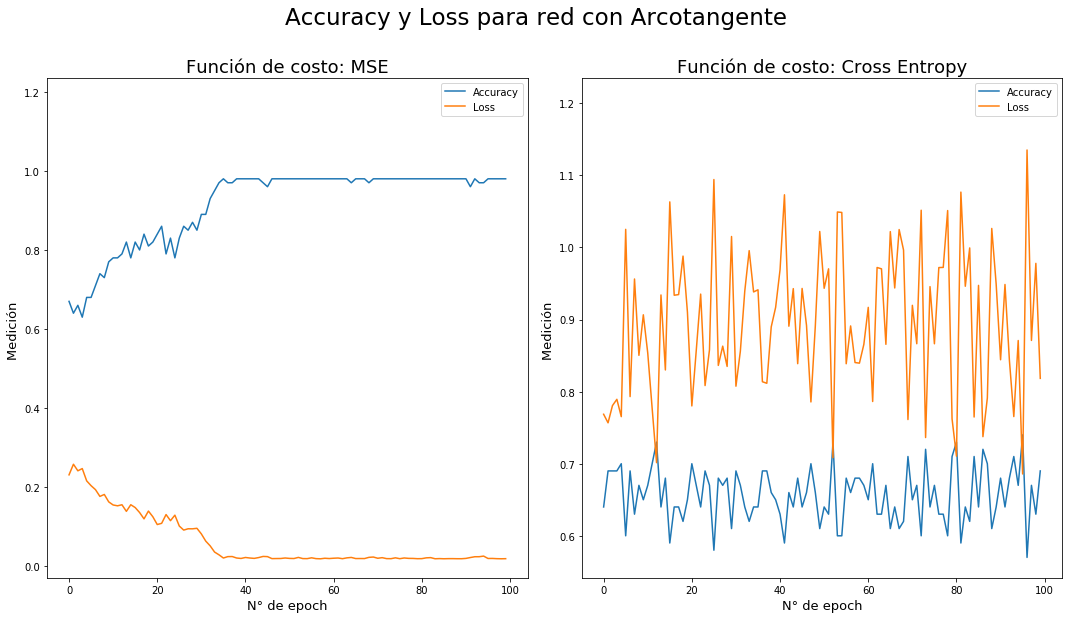

Resultados configuración: Arcotangente - MSE
Accuracy final:  98.0 %
Loss final:  0.0191816894912
Tiempo total:  5.02 segundos


Resultados configuración: Arcotangente - Cross Entropy
Accuracy final:  69.0 %
Loss final:  0.818407193533
Tiempo total:  4.288 segundos




In [16]:
#Busqueda del maximo valor en los resultados para ajustes de graficos
x = [1,max(loss_am),max(loss_ac)]
valor_maximo = max(x)+0.1


plt.figure(1, figsize=(15,8))
plt.suptitle("Accuracy y Loss para red con Arcotangente", fontsize=23, y=1.07)
plt.subplot(121)
plt.title("Función de costo: MSE",fontsize=18)
plt.plot(range(len(accuracy_am)), accuracy_am, label="Accuracy")
plt.plot(range(len(loss_am)), loss_am, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()
plt.subplot(122)
plt.title("Función de costo: Cross Entropy",fontsize=18)
plt.plot(range(len(accuracy_ac)), accuracy_ac, label="Accuracy")
plt.plot(range(len(loss_ac)), loss_ac, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()


plt.tight_layout() 
plt.show()

print("Resultados configuración: Arcotangente - MSE")
print("Accuracy final: ",accuracy_am[-1]*100,"%")
print("Loss final: ",loss_am[-1])
print("Tiempo total: ", round(np.sum(tiempo_am),3),"segundos")
print("\n")

print("Resultados configuración: Arcotangente - Cross Entropy")
print("Accuracy final: ",accuracy_ac[-1]*100,"%")
print("Loss final: ",loss_ac[-1])
print("Tiempo total: ", round(np.sum(tiempo_ac),3),"segundos")
print("\n")


Con respecto al tiempo, ambas redes (arcotangente - mse y arcotangente - cross entropy) tuvieron una duración del entrenamiento similar. Sin embargo, la combinación arcotangente - mse muestra resultados significativamente superiores a los obtenidos por la combinación arcotangente - cross entropy. La primera tiene un *accuracy* de 98%, mientras que la segunda combinación en su último epoch alcanza un 69%.

Es interesante notar que en el caso de arcotangente - cross entropy, la pérdida (*loss*) por epoch varía considerablemente entre cada una de ellas. Si bien uno de sus menores valores se obtuvo cerca de la iteración #80, *loss* vuelve a  aumentar en los siguientes epochs. 

En el caso de arcotangente - mse, el comportamiento del algoritmo es más ordenado. El *accuracy* tiende a aumentar a medida que aumenta el número de epochs mientras que la pérdida disminuye con el correr del tiempo. 

<a id="segundo"></a>
## 2. Comparar back-propagation (BP) de Keras

Keras es una de las librerı́as más populares para desarrollar nuevos modelos de redes neuronales o implementar eficientemente modelos conocidos con fines prácticos, puesto que ofrece una interfaz para poder trabajar de una manera mucho mas simple además de permitir también el manejo de configuraciones más específicas.  

Como actividad pedagógica se comparó el algoritmo implementado en la sección anterior con el de alto nivel de la librería __[keras](https://keras.io/)__ . Se compararon los algoritmos sobre el mismo dataset con la misma arquitectura utilizada anteriormente, es decir, dos capas ocultas (con 32 y 16 neuronas respectivamente), 3 neuronas en la capa de salida con función de activación softmax, optimizador Descenso Gradiente Estocástico (SGD) con tasa de aprendizaje fija.

Utilizando la arquitectura definida anteriormente, se realizaron las comparaciones teniendo en cuenta las siguientes combinaciones de funciones de activación y de costo:
>* Sigmoid y Cross Entropy
>* Sigmoid y Median Squared Error
>* ReLU y Cross Entropy
>* ReLU y Median Squared Error

Los resultados fueron los siguientes:


### Red utilizando Sigmoid y Cross Entropy

a) Defina, a través de la interfaz de keras, la arquitectura de la red, con las funciones de activación para comparar con la sección anterior.

In [17]:
from keras.models import Sequential
from keras.layers.core import Dense

In [18]:
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(3, activation="softmax"))

b) Defina, a través de la interfaz de keras, el optimizador de la red, en conjunto con la función de error, para poder comparar con la sección anterior.

In [19]:
from keras.optimizers import SGD

In [20]:
model.compile(optimizer=SGD(lr=0.1),loss="categorical_crossentropy", metrics=["accuracy"])

c) Entrene (ajuste) los pesos de la red definida mediante keras, reportando los mismos gráficos de la sección anterior para poder comparar. Si hay diferencias en la convergencia del algoritmo ¿A qué podría deverse? si hay una gran diferencia en los tiempos de entrenamiento ¿A qué podría deverse?

### Implementación con Keras

In [21]:
#Callback para medir los tiempos por epoch de keras
# Se utilizara en todas las combinaciones (sigmoid-cross entropy; sigmoid-mse, ReLu-cross entropy, ReLu-mse)
import time
class TimingCallback(keras.callbacks.Callback):
    def __init__(self):
        self.logs=[]
    def on_epoch_begin(self,epoch, logs={}):
        self.starttime=time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(time.time()-self.starttime)
    

In [22]:
#Numero de epochs que se utilizará en todas las combinaciones
num_epochs = 100

In [23]:
#Entrenamiento de red utilizando keras. Función activación:  sigmoide  Función de costo: cross entropy
tiempos_keras_sc = TimingCallback()
keras_sc = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=0, callbacks=[tiempos_keras_sc])
accuracy_keras_sc = keras_sc.history['acc']
loss_keras_sc = keras_sc.history['loss']

### Implementación Propia

In [24]:
nn_sc = RedNeuronal(4, [32, 16], 3, "sigmoid", "crossentropy")
nn_sc.train(x_train, y_onehot_train, num_epochs, 0.1, verbose = False)
loss_propia_sc = nn_sm.log['loss']
accuracy_propia_sc = nn_sm.log['accuracy']
tiempo_propia_sc = nn_sm.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.105259722701 - acc: 0.86


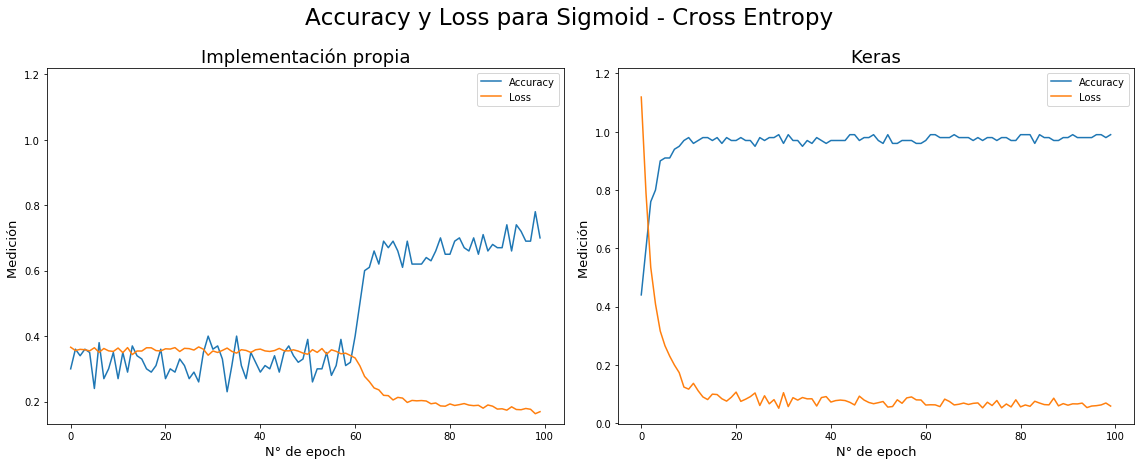



Accuracy Implementación Propia = 70.0%
Accuracy Keras = 99.0%


Loss Implementación Propia = 0.1692
Loss Keras = 0.0583


In [25]:
x = [max(accuracy_propia_sc), max(loss_propia_sc), max(accuracy_keras_sc), max(loss_keras_sc)]
valor_maximo = max(x)+0.1

plt.figure(1, figsize=(16,6))
plt.suptitle("Accuracy y Loss para Sigmoid - Cross Entropy \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(accuracy_propia_sc)), accuracy_propia_sc, label="Accuracy")
plt.plot(range(len(loss_propia_sc)), loss_propia_sc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()
plt.ylim(ymax=valor_maximo)


plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(accuracy_keras_sc)), accuracy_keras_sc, label="Accuracy")
plt.plot(range(len(loss_keras_sc)), loss_keras_sc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()
plt.ylim(ymax=valor_maximo)


plt.tight_layout() 
plt.show()
print("\n")
print("Accuracy Implementación Propia = "+str(round(accuracy_propia_sc[-1]*100,2))+"%")
print("Accuracy Keras = "+str(round(accuracy_keras_sc[-1]*100,2))+"%")
print("\n")
print("Loss Implementación Propia = "+str(round(loss_propia_sc[-1],4)))
print("Loss Keras = "+str(round(loss_keras_sc[-1],4)))

Para la combiación *sigmoid - cross entropy*, el algoritmo que utiliza Keras es significativamente superior a la implementación creada para esta tarea. Mientras keras alcanza un *accuracy* de 99% en el epoch #100, la implementación propia alcanza solo un 70% para este mismo número de iteraciones. 

El algoritmo implementado en Keras converge mucho más rápido que la implementación propia. Este último requiere una cantidad de iteraciones bastante alta para comenzar a 'aprender' y así mejorar significativamente el *accuracy*

La pérdida *loss* de Keras en la ultima iteración es muy menor a la obtenida por la implementación propia.

Sospechamos que el algoritmo de Keras es más eficaz y eficiente comparado al algoritmo propio debido a que el primero debe utilizar métodos optimizados para los cálculos matemáticos. Esto implicaría que la diferencia crece al aumentar el número de iteraciones. Hay que recordar que la implementación propia solo utiliza la librería numpy para obtener resultados de algunas operaciones matemáticas.



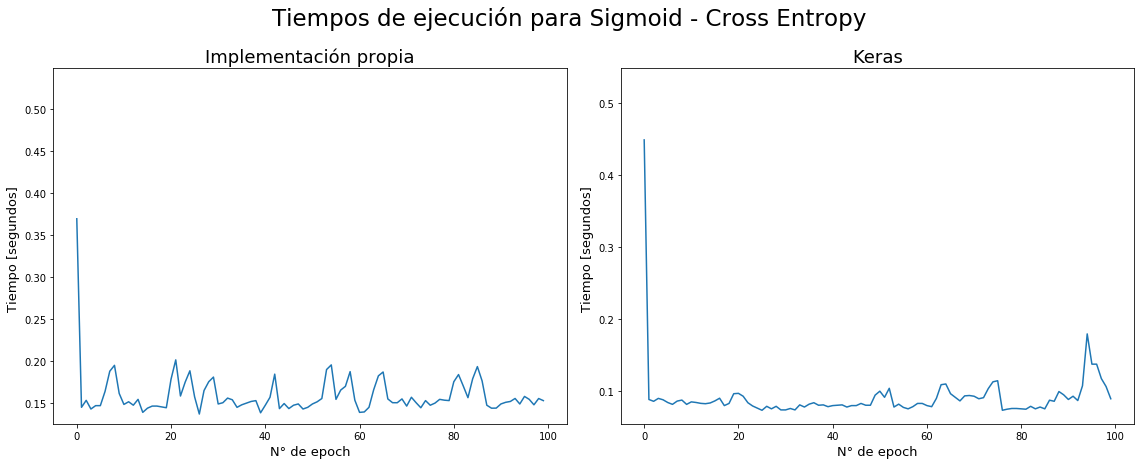

El tiempo total del entrenamiento con nuestra implementación fue de 15.92 segundos
El tiempo total del entrenamiento con keras fue de 9.16 segundos


In [26]:
x = [max(tiempo_propia_sc),max(tiempos_keras_sc.logs)]
valor_maximo = max(x)+0.1
plt.figure(1, figsize=(16,6))

plt.suptitle("Tiempos de ejecución para Sigmoid - Cross Entropy \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(tiempo_propia_sc)), tiempo_propia_sc)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(tiempos_keras_sc.logs)), tiempos_keras_sc.logs)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)


plt.tight_layout() 
plt.show()

print("El tiempo total del entrenamiento con nuestra implementación fue de "+str(round(sum(tiempo_propia_sc),2))+" segundos")
print("El tiempo total del entrenamiento con keras fue de "+str(round(sum(tiempos_keras_sc.logs),2))+" segundos")


El tiempo de ejecución del algoritmo desarrollado en Keras es un tercio más rápido que la implementación propia, por lo que Keras es mucho más eficiente. 

Es curioso notar que mientras los tiempos de entrenamiento tienden a mantenerse o disminuir en Keras, en el caso de la implementación propia estos tiempos no siguen un patrón determinado y varían mucho por epoch. 

## Red con Sigmoid y Mean Squared Error

a) Defina, a través de la interfaz de keras, la arquitectura de la red, con las funciones de activación para comparar con la sección anterior.

In [27]:
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(3, activation="softmax"))

b) Defina, a través de la interfaz de keras, el optimizador de la red, en conjunto con la función de error, para poder comparar con la sección anterior.

In [28]:
model.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])

c) Entrene (ajuste) los pesos de la red definida mediante keras, reportando los mismos gráficos de la sección anterior para poder comparar. Si hay diferencias en la convergencia del algoritmo ¿A qué podría deverse? si hay una gran diferencia en los tiempos de entrenamiento ¿A qué podría deverse?

### Implementación con Keras

In [29]:
#Entrenamiento de red utilizando keras. Función activación:  sigmoide  Función de costo: median squared error
tiempos_keras_sm = TimingCallback()
keras_sm = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=0, callbacks=[tiempos_keras_sm])
accuracy_keras_sm = keras_sm.history['acc']
loss_keras_sm = keras_sm.history['loss']

### Implementación propia

In [30]:
nn_sm = RedNeuronal(4, [32, 16], 3, "sigmoid", "mse")
nn_sm.train(x_train, y_onehot_train, num_epochs, 0.1, verbose = False)
loss_propia_sm = nn_sm.log['loss']
accuracy_propia_sm = nn_sm.log['accuracy']
tiempo_propia_sm = nn_sm.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: mse
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.108109907701 - acc: 0.89


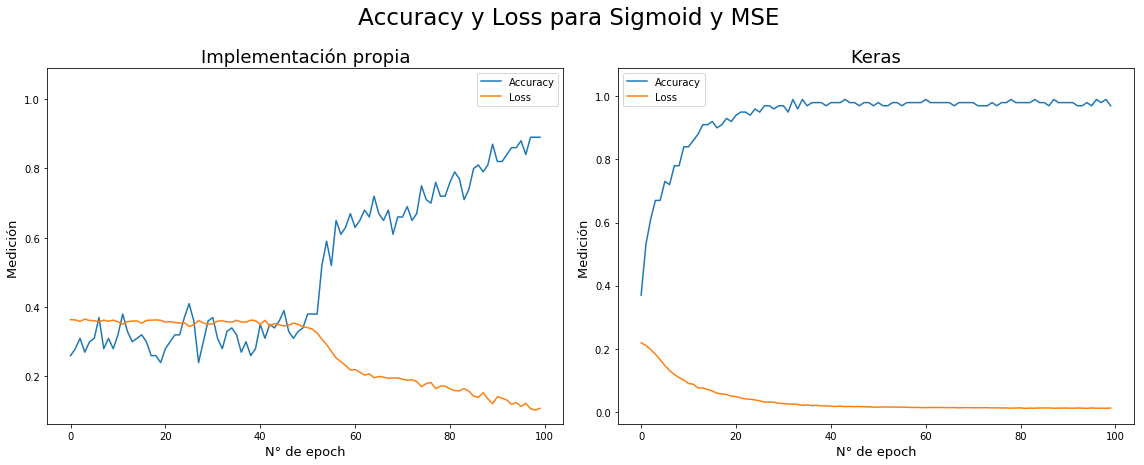



Accuracy Implementación Propia = 89.0%
Accuracy Keras = 97.0%


Loss Implementación Propia = 0.1081
Loss Keras= 0.012


In [31]:
x = [max(accuracy_propia_sm),max(loss_propia_sm), max(accuracy_keras_sm), max(loss_keras_sm)]
valor_maximo = max(x)+0.1

plt.figure(1, figsize=(16,6))
plt.suptitle("Accuracy y Loss para Sigmoid y MSE \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(accuracy_propia_sm)), accuracy_propia_sm, label="Accuracy")
plt.plot(range(len(loss_propia_sm)), loss_propia_sm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(accuracy_keras_sm)), accuracy_keras_sm, label="Accuracy")
plt.plot(range(len(loss_keras_sm)), loss_keras_sm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.legend()

plt.tight_layout() 
plt.show()
print("\n")
print("Accuracy Implementación Propia = "+str(round(accuracy_propia_sm[-1]*100,2))+"%")
print("Accuracy Keras = "+str(round(accuracy_keras_sm[-1]*100,2))+"%")
print("\n")
print("Loss Implementación Propia = "+str(round(loss_propia_sm[-1],4)))
print("Loss Keras= "+str(round(loss_keras_sm[-1],4)))

De manera similar al caso anterior, el algoritmo utilizado por Keras es significativamente superior a la implementación propia. Keras alcanza un *accuracy* del 97% mientras que la implementación propia alcanza un 89%. 





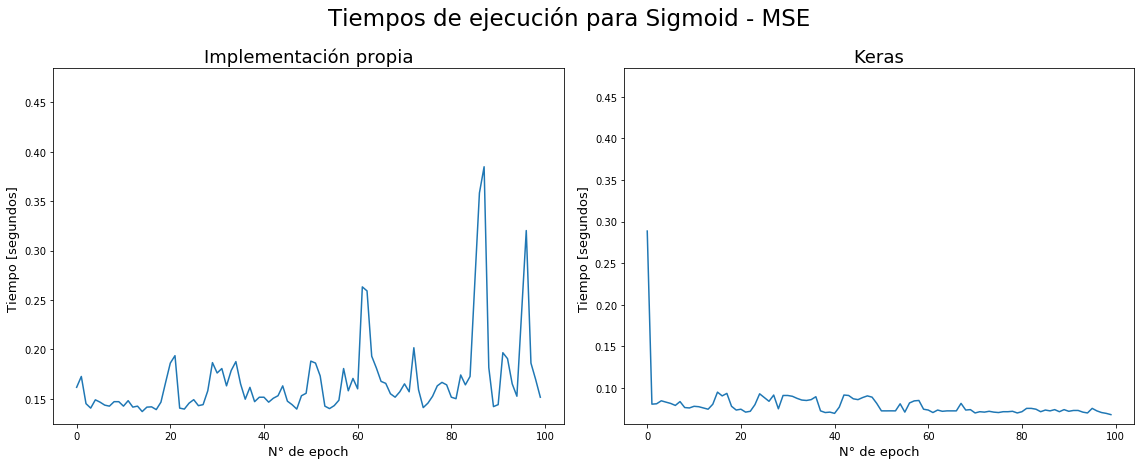

El tiempo total del entrenamiento con nuestra implementación fue de 16.86 segundos
El tiempo total del entrenamiento con keras fue de 8.0 segundos


In [32]:
x = [max(tiempo_propia_sm), max(tiempos_keras_sm.logs)]
valor_maximo = max(x)+0.1
plt.figure(1, figsize=(16,6))
plt.suptitle("Tiempos de ejecución para Sigmoid - MSE \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(tiempo_propia_sm)), tiempo_propia_sm)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(tiempos_keras_sm.logs)), tiempos_keras_sm.logs)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)


plt.tight_layout() 
plt.show()

print("El tiempo total del entrenamiento con nuestra implementación fue de "+str(round(sum(tiempo_propia_sm),2))+" segundos")
print("El tiempo total del entrenamiento con keras fue de "+str(round(sum(tiempos_keras_sm.logs),2))+" segundos")


El tiempo que requiere Keras para realizar 100 epochs es menos de la mitad del tiempo que requiere el algoritmo propio para cumplir con ese mismo número de iteraciones. Al igual que el caso anterior, los tiempos por epochs en el algoritmo propio tienden a ser muy diferentes entre si. En el caso de los tiempos de Keras por epoch, estos tienden a disminuir significativamente luego de las primeras iteraciones. 



Con respecto a los resultados obtenidos en cuanto a *accuracy* y *loss*, en este punto como equipo nos hicimos la siguiente pregunta: **¿Será que la implementación propia necesita de un mayor número de epochs para igualar o superar el accuracy alcanzado por Keras?**  Al aumentar el número de epochs obtuvimos lo siguiente:


#### Aumento del número de epochs en la combinación Sigmoid - MSE

In [39]:
#Aumento del numero de epochs del algoritmo utilizado por Keras (Se reinicia la red)
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(3, activation="softmax"))
model.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])
tiempos_keras_sm = TimingCallback()
keras_sm = model.fit(x_train, y_onehot_train, epochs=400, batch_size=1, verbose=0, callbacks=[tiempos_keras_sm])
accuracy_keras_sm = keras_sm.history['acc']
loss_keras_sm = keras_sm.history['loss']

#Aumento del numero de epochs del algoritmo propio (Se reinicia la red)
nn_sm = RedNeuronal(4, [32, 16], 3, "sigmoid", "mse")
nn_sm.train(x_train, y_onehot_train, 400, 0.1, verbose = False)
loss_propia_sm = nn_sm.log['loss']
accuracy_propia_sm = nn_sm.log['accuracy']
tiempo_propia_sm = nn_sm.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: mse
Comienza entrenamiento de red 
Resultado de training set de 400 epochs: loss 0.0117778842608 - acc: 0.99


#### Resultados del aumento del número de epochs en la combinación Sigmoid - MSE

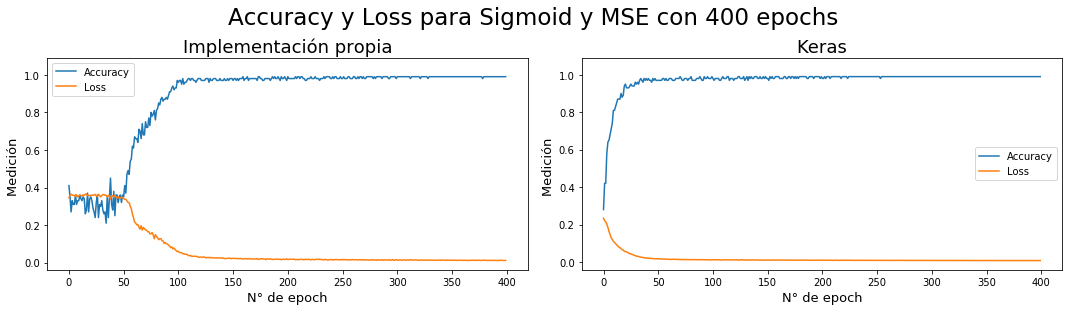



Accuracy Implementación Propia = 99.0%
Accuracy Keras = 99.0%


Loss Implementación Propia = 0.0118
Loss Keras= 0.0076


Tiempo total Implementación Propia:  59.747 segundos
Tiempo total Keras:  31.296 segundos


In [40]:
x = [max(accuracy_propia_sm),max(loss_propia_sm), max(accuracy_keras_sm), max(loss_keras_sm)]
valor_maximo = max(x)+0.1
plt.figure(1, figsize=(15,4))
plt.suptitle("Accuracy y Loss para Sigmoid y MSE con 400 epochs \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(accuracy_propia_sm)), accuracy_propia_sm, label="Accuracy")
plt.plot(range(len(loss_propia_sm)), loss_propia_sm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(accuracy_keras_sm)), accuracy_keras_sm, label="Accuracy")
plt.plot(range(len(loss_keras_sm)), loss_keras_sm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.tight_layout() 
plt.show()
print("\n")
print("Accuracy Implementación Propia = "+str(round(accuracy_propia_sm[-1]*100,2))+"%")
print("Accuracy Keras = "+str(round(accuracy_keras_sm[-1]*100,2))+"%")
print("\n")
print("Loss Implementación Propia = "+str(round(loss_propia_sm[-1],4)))
print("Loss Keras= "+str(round(loss_keras_sm[-1],4)))
print("\n")
print("Tiempo total Implementación Propia: ", round(np.sum(tiempo_propia_sm),3),"segundos")
print("Tiempo total Keras: ", round(np.sum(tiempos_keras_sm.logs),3),"segundos")


**¡La hipótesis es verdadera!** La implementación propia para este caso necesita de un mayor número de epochs para poder alcanzar el *accuracy* alcanzado por Keras. Esto pretende deducir que el algoritmo propio "aprende" más lento (converge mas lento) que el de la librería Keras. Además, notar que el *loss* alcanzado por ambos algoritmos es ligeramente similar. 

Si bien después de 400 epochs ambos algoritmos alcanzan el mismo *accuracy*, el algoritmo de la librería Keras alcanza el resultado en casi la mitad del tiempo que requiere el algoritmo implementado por nosotros.


## Red con ReLU y Crossentropy

**Nota:** Para este análisis el número de epochs vuelve a ser num_epochs = 100

a) Defina, a través de la interfaz de keras, la arquitectura de la red, con las funciones de activación para comparar con la sección anterior.

In [49]:
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(3, activation="softmax"))

b) Defina, a través de la interfaz de keras, el optimizador de la red, en conjunto con la función de error, para poder comparar con la sección anterior.

In [50]:
model.compile(optimizer=SGD(lr=0.1),loss="categorical_crossentropy", metrics=["accuracy"])

c) Entrene (ajuste) los pesos de la red definida mediante keras, reportando los mismos gráficos de la sección anterior para poder comparar. Si hay diferencias en la convergencia del algoritmo ¿A qué podría deverse? si hay una gran diferencia en los tiempos de entrenamiento ¿A qué podría deverse?

### Implementación con Keras

In [51]:
#Entrenamiento de red utilizando keras. Función activación:  relu  Función de costo: cross entropy
tiempos_keras_rc = TimingCallback()
keras_rc = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=0, callbacks=[tiempos_keras_rc])
accuracy_keras_rc = keras_sm.history['acc']
loss_keras_rc = keras_sm.history['loss']

### Implementación propia

In [52]:
nn_rc = RedNeuronal(4, [32,16], 3, "relu", "crossentropy")
nn_rc.train(x_train, y_onehot_train, num_epochs, 0.1, verbose = False)
loss_propia_rc = nn_rc.log['loss']
accuracy_propia_rc = nn_rc.log['accuracy']
tiempo_propia_rc = nn_rc.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: relu
	Función de costo: crossentropy
Comienza entrenamiento de red 


C:\Users\gonza\AppData\Local\conda\conda\envs\redesneuronales\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in maximum
C:\Users\gonza\AppData\Local\conda\conda\envs\redesneuronales\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


Resultado de training set de 100 epochs: loss nan - acc: 0.33


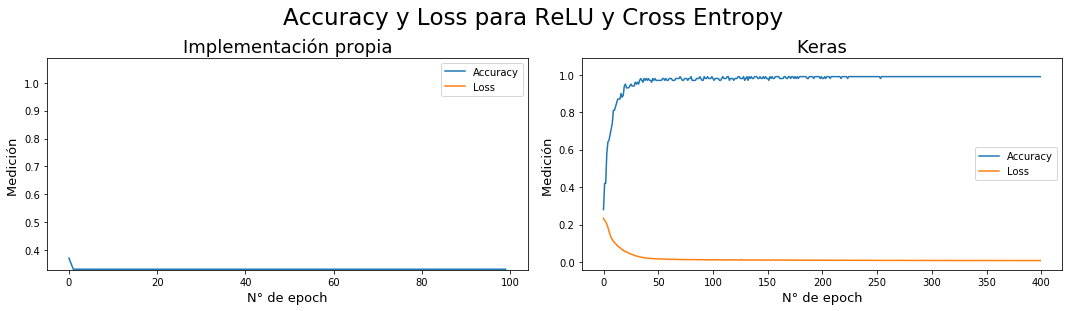



Accuracy Implementación Propia = 33.0%
Accuracy Keras = 99.0%


Loss Implementación Propia = nan
Loss Keras= 0.0076


In [53]:
x = [max(accuracy_propia_rc),max(loss_propia_rc),max(accuracy_keras_rc),max(loss_keras_rc)]
valor_maximo = max(x)+0.1

plt.figure(1, figsize=(15,4))
plt.suptitle("Accuracy y Loss para ReLU y Cross Entropy \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(accuracy_propia_rc)), accuracy_propia_rc, label="Accuracy")
plt.plot(range(len(loss_propia_rc)), loss_propia_rc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(accuracy_keras_rc)), accuracy_keras_rc, label="Accuracy")
plt.plot(range(len(loss_keras_rc)), loss_keras_rc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.tight_layout() 
plt.show()
print("\n")
print("Accuracy Implementación Propia = "+str(round(accuracy_propia_rc[-1]*100,2))+"%")
print("Accuracy Keras = "+str(round(accuracy_keras_rc[-1]*100,2))+"%")
print("\n")
print("Loss Implementación Propia = "+str(round(loss_propia_rc[-1],4)))
print("Loss Keras= "+str(round(loss_keras_rc[-1],4)))

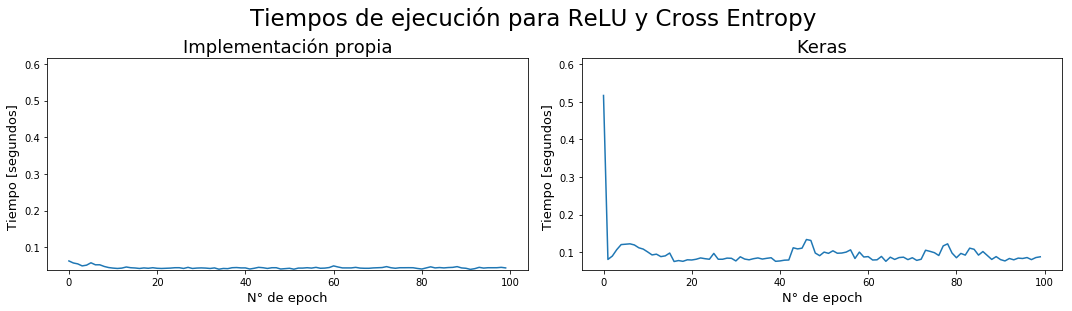

El tiempo total del entrenamiento con nuestra implementación fue de 4.44 segundos
El tiempo total del entrenamiento con keras fue de 9.59 segundos


In [54]:
valor_maximo = max([max(tiempo_propia_rc),max(tiempos_keras_rc.logs)])

plt.figure(1, figsize=(15,4))
plt.suptitle("Tiempos de ejecución para ReLU y Cross Entropy \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(tiempo_propia_rc)), tiempo_propia_rc)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo+0.1)

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(tiempos_keras_rc.logs)), tiempos_keras_rc.logs)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo+0.1)

plt.tight_layout() 
plt.show()

print("El tiempo total del entrenamiento con nuestra implementación fue de "+str(round(sum(tiempo_propia_rc),2))+" segundos")
print("El tiempo total del entrenamiento con keras fue de "+str(round(sum(tiempos_keras_rc.logs),2))+" segundos")


Nuevamente, en este caso se puede visualizar como el algoritmo de Keras se destaca por ser eficaz. **Keras en su último epoch tuvo un *accuracy* de 99%!**

Si bien el algoritmo propio realiza los 100 epochs en la mitad del tiempo que requiere Keras, el *accuracy* alcanzado es deficiente. 

Los resultados permiten visualizar que el algoritmo propio no es capaz de elevar el *accuracy* sobre el 33%. Esta situación se describió anteriormente y se mencionó que el algoritmo implementado no entrega resultados eficientes cuando se utiliza ReLU junto a una red con dos capas ocultas. Dada esta situación, se repitió la comparación pero considerando una red con solo una capa oculta compuesta por 32 neuronas. Además, teniendo en cuenta que la implementación propia puede ser lenta en converger, el número de epochs se cambió a 400.

Los resultados fueron los siguientes:


#### Repetición de comparación para ReLU -Cross Entropy, con una capa oculta y cantidad de neuronas igual a 32.  Número de epochs = 400

In [55]:
num_epochs = 400

#Implementación Keras(Se reinicia la red)
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="relu"))
model.add(Dense(3, activation="softmax"))
model.compile(optimizer=SGD(lr=0.1),loss="categorical_crossentropy", metrics=["accuracy"])
tiempos_keras_rc = TimingCallback()
keras_rc = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=0, callbacks=[tiempos_keras_rc])
accuracy_keras_rc = keras_rc.history['acc']
loss_keras_rc = keras_rc.history['loss']

#Algoritmo propio (Se reinicia la red)
nn_rc = RedNeuronal(4, [32], 3, "relu", "crossentropy")
nn_rc.train(x_train, y_onehot_train, num_epochs, 0.1, verbose = False)
loss_propia_rc = nn_rc.log['loss']
accuracy_propia_rc = nn_rc.log['accuracy']
tiempo_propia_rc = nn_rc.log['tiempo']

Red Neuronal creada
	Capas: 4 [32] 3
	Activación interna: relu
	Función de costo: crossentropy
Comienza entrenamiento de red 
Resultado de training set de 400 epochs: loss 1.526479523 - acc: 0.83


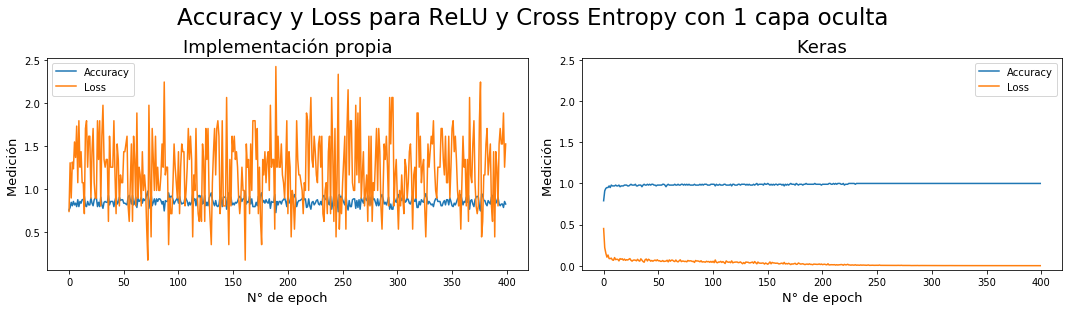



Accuracy Implementación Propia = 83.0%
Accuracy Keras = 100.0%


Loss Implementación Propia = 1.5265
Loss Keras= 0.0015


Tiempo total Implementación Propia:  12.358 segundos
Tiempo total Keras:  35.223 segundos


In [57]:
x = [max(accuracy_propia_rc), max(loss_propia_rc),max(accuracy_keras_rc), max(loss_keras_rc)]
valor_maximo = max(x)+0.1
plt.figure(1, figsize=(15,4))
plt.suptitle("Accuracy y Loss para ReLU y Cross Entropy con 1 capa oculta \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(accuracy_propia_rc)), accuracy_propia_rc, label="Accuracy")
plt.plot(range(len(loss_propia_rc)), loss_propia_rc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(accuracy_keras_rc)), accuracy_keras_rc, label="Accuracy")
plt.plot(range(len(loss_keras_rc)), loss_keras_rc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.tight_layout() 
plt.show()
print("\n")
print("Accuracy Implementación Propia = "+str(round(accuracy_propia_rc[-1]*100,2))+"%")
print("Accuracy Keras = "+str(round(accuracy_keras_rc[-1]*100,2))+"%")
print("\n")
print("Loss Implementación Propia = "+str(round(loss_propia_rc[-1],4)))
print("Loss Keras= "+str(round(loss_keras_rc[-1],4)))
print("\n")
print("Tiempo total Implementación Propia: ", round(np.sum(tiempo_propia_rc),3),"segundos")
print("Tiempo total Keras: ", round(np.sum(tiempos_keras_rc.logs),3),"segundos")


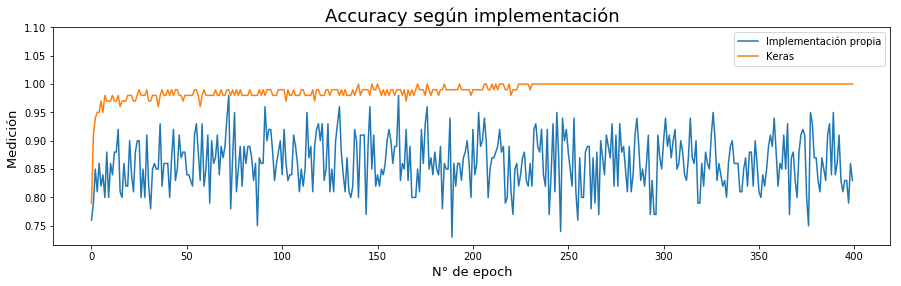

In [58]:
plt.figure(1, figsize=(15,4))
x = [max(accuracy_keras_rc), max(accuracy_propia_rc)]
valor_maximo = max(x)+0.1
plt.title("Accuracy según implementación",fontsize=18)
plt.plot(range(len(accuracy_propia_rc)), accuracy_propia_rc, label="Implementación propia")
plt.plot(range(len(accuracy_keras_rc)), accuracy_keras_rc, label="Keras")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.legend()
plt.show()

El algoritmo de Keras alcanza un 100% de *accuracy* pasado los 200 epochs, en el caso del algoritmo propio este valor varía epoch  por epoch. En la última iteración alcanzó un 83%. 

Con respecto a la pérdida, el algoritmo de Keras disminuye esta cifra con el correr de las iteraciones. En el caso del algoritmo propio esta situación no se repite de la misma forma, ya que *loss* varía entre cada epoch. 

Si bien el *accuracy* final obtenido por el algoritmo propio no es el mejor, no se debe dejar de lado que el tiempo que requirió para llegar a este valor fue de un tercio del tiempo que requirió el algoritmo diseñado en Keras. ¡Es una buena noticia para el algoritmo propio! Sobre todo si alguna tarea no requiere resultados tan precisos.


## Red con ReLU y Mean Squared Error

a) Defina, a través de la interfaz de keras, la arquitectura de la red, con las funciones de activación para comparar con la sección anterior.

In [59]:
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(3, activation="softmax"))

b) Defina, a través de la interfaz de keras, el optimizador de la red, en conjunto con la función de error, para poder comparar con la sección anterior.

In [60]:
model.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])

c) Entrene (ajuste) los pesos de la red definida mediante keras, reportando los mismos gráficos de la sección anterior para poder comparar. Si hay diferencias en la convergencia del algoritmo ¿A qué podría deverse? si hay una gran diferencia en los tiempos de entrenamiento ¿A qué podría deverse?

### Implementación con Keras

In [61]:
#Entrenamiento de red utilizando keras. Función activación:  relu  Función de costo: mse
tiempos_keras_rm = TimingCallback()
keras_rm = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=0, callbacks=[tiempos_keras_rm])
accuracy_keras_rm = keras_sm.history['acc']
loss_keras_rm = keras_sm.history['loss']

### Implementación Propia

In [62]:
nn_rm = RedNeuronal(4, [32,16], 3, "relu", "mse")
nn_rm.train(x_train, y_onehot_train, num_epochs, 0.1, verbose = False)
loss_propia_rm = nn_rm.log['loss']
accuracy_propia_rm = nn_rm.log['accuracy']
tiempo_propia_rm = nn_rm.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: relu
	Función de costo: mse
Comienza entrenamiento de red 
Resultado de training set de 400 epochs: loss 0.66 - acc: 0.34


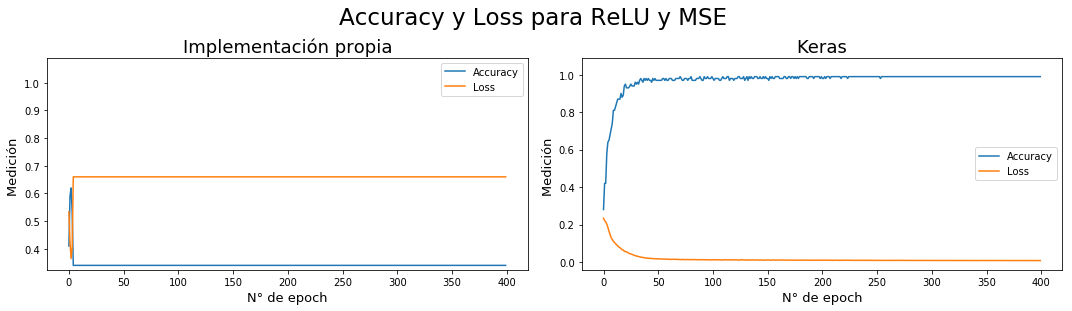



Accuracy Implementación Propia = 34.0%
Accuracy Keras = 99.0%


Loss Implementación Propia = 0.66
Loss Keras= 0.0076


In [63]:
x = [max(accuracy_propia_rm),max(loss_propia_rm), max(accuracy_keras_rm), max(loss_keras_rm)]
valor_maximo = max(x)+0.1
plt.figure(1, figsize=(15,4))
plt.suptitle("Accuracy y Loss para ReLU y MSE \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(accuracy_propia_rm)), accuracy_propia_rm, label="Accuracy")
plt.plot(range(len(loss_propia_rm)), loss_propia_rm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(accuracy_keras_rm)), accuracy_keras_rm, label="Accuracy")
plt.plot(range(len(loss_keras_rm)), loss_keras_rm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.tight_layout() 
plt.show()
print("\n")
print("Accuracy Implementación Propia = "+str(round(accuracy_propia_rm[-1]*100,2))+"%")
print("Accuracy Keras = "+str(round(accuracy_keras_rm[-1]*100,2))+"%")
print("\n")
print("Loss Implementación Propia = "+str(round(loss_propia_rm[-1],4)))
print("Loss Keras= "+str(round(loss_keras_rm[-1],4)))

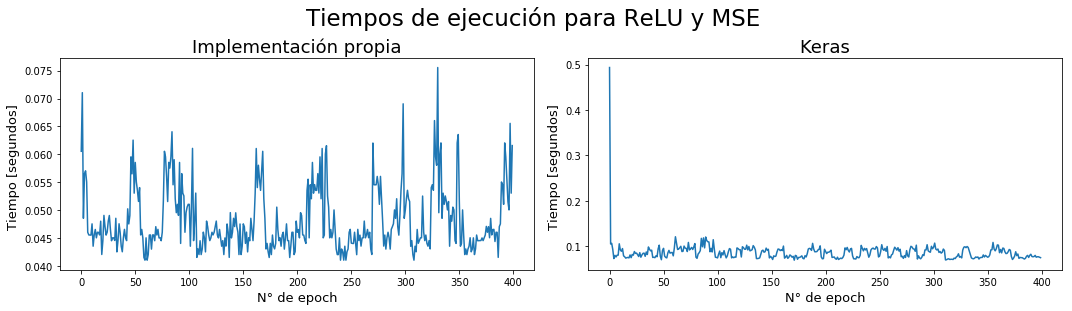

El tiempo total del entrenamiento con nuestra implementación fue de 19.29 segundos
El tiempo total del entrenamiento con keras fue de 34.69 segundos


In [64]:
plt.figure(1, figsize=(15,4))
plt.suptitle("Tiempos de ejecución para ReLU y MSE \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(tiempo_propia_rm)), tiempo_propia_rm)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(tiempos_keras_rm.logs)), tiempos_keras_rm.logs)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)

plt.tight_layout() 
plt.show()

print("El tiempo total del entrenamiento con nuestra implementación fue de "+str(round(sum(tiempo_propia_rm),2))+" segundos")
print("El tiempo total del entrenamiento con keras fue de "+str(round(sum(tiempos_keras_rm.logs),2))+" segundos")


Los resultados obtenidos por la implementación propia dejan de ser lo esperado. Dado que en la [sección 1](#primero) se aclaró que el algoritmo entregaba resultados deficientes al incorporar dos capas ocultas. Se hizo la comparación utilizando solo 1 capa oculta de tamaño 32 neuronas.

Los resultados fueron los siguientes:

#### Repetición de comparación para ReLU - MSE, con una capa oculta y cantidad de neuronas igual a 32. 

In [71]:
num_epochs = 100

#Implementación Keras(Se reinicia la red)
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="relu"))
model.add(Dense(3, activation="softmax"))
model.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])
tiempos_keras_rm = TimingCallback()
keras_rm = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=0, callbacks=[tiempos_keras_rm])
accuracy_keras_rm = keras_rm.history['acc']
loss_keras_rm = keras_rm.history['loss']

#Algoritmo propio (Se reinicia la red)
nn_rm = RedNeuronal(4, [32], 3, "relu", "mse")
nn_rm.train(x_train, y_onehot_train, num_epochs, 0.1, verbose = False)
loss_propia_rm = nn_rm.log['loss']
accuracy_propia_rm = nn_rm.log['accuracy']
tiempo_propia_rm = nn_rm.log['tiempo']

Red Neuronal creada
	Capas: 4 [32] 3
	Activación interna: relu
	Función de costo: mse
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.0120727335013 - acc: 0.99


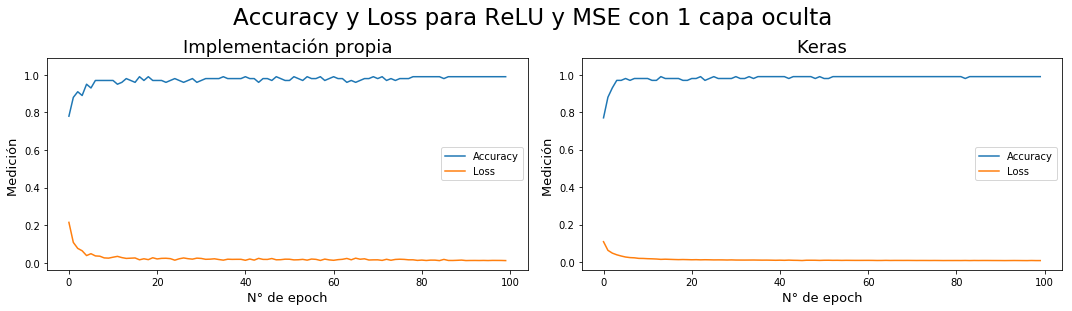



Accuracy Implementación Propia = 99.0%
Accuracy Keras = 99.0%


Loss Implementación Propia = 0.0121
Loss Keras= 0.0077


Tiempo total Implementación Propia:  3.408 segundos
Tiempo total Keras:  8.395 segundos


In [72]:
x = [max(accuracy_propia_rm), max(loss_propia_rm),max(accuracy_keras_rm), max(loss_keras_rm)]
valor_maximo = max(x)+0.1
plt.figure(1, figsize=(15,4))
plt.suptitle("Accuracy y Loss para ReLU y MSE con 1 capa oculta \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(accuracy_propia_rm)), accuracy_propia_rm, label="Accuracy")
plt.plot(range(len(loss_propia_rm)), loss_propia_rm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(accuracy_keras_rm)), accuracy_keras_rm, label="Accuracy")
plt.plot(range(len(loss_keras_rm)), loss_keras_rm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.tight_layout() 
plt.show()
print("\n")
print("Accuracy Implementación Propia = "+str(round(accuracy_propia_rm[-1]*100,2))+"%")
print("Accuracy Keras = "+str(round(accuracy_keras_rm[-1]*100,2))+"%")
print("\n")
print("Loss Implementación Propia = "+str(round(loss_propia_rm[-1],4)))
print("Loss Keras= "+str(round(loss_keras_rm[-1],4)))
print("\n")
print("Tiempo total Implementación Propia: ", round(np.sum(tiempo_propia_rm),3),"segundos")
print("Tiempo total Keras: ", round(np.sum(tiempos_keras_rm.logs),3),"segundos")


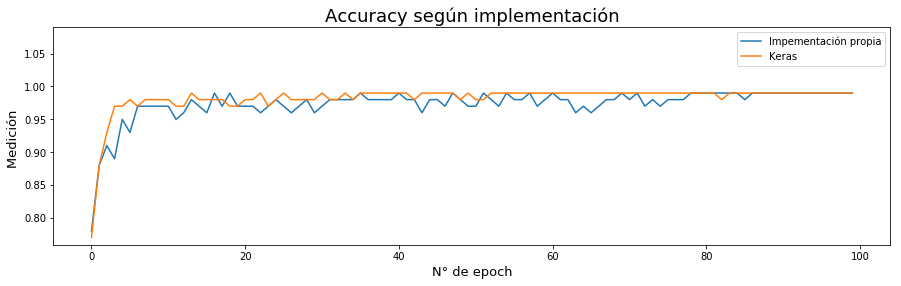

In [73]:
plt.figure(1, figsize=(15,4))
x = [max(accuracy_keras_rm), max(accuracy_propia_rm)]
valor_maximo = max(x)+0.1
plt.title("Accuracy según implementación",fontsize=18)
plt.plot(range(len(accuracy_propia_rm)), accuracy_propia_rm, label="Impementación propia")
plt.plot(range(len(accuracy_keras_rm)), accuracy_keras_rm, label="Keras")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.legend()
plt.show()

Los resultados anteriores permiten visualizar que con una capa oculta de 32 neuronas el algoritmo propio entrega resultados muy similares a los posibles de obtener por el algoritmo de keras, con los mismos parámetros. Ambos algoritmos convergen de manera rápida y muy similar, alcanzando un *accuracy* final de 99%. 

Con respecto a la pérdida, este valor es menor levemente en el algoritmo de Keras en comparación con el valor obtenido por el algoritmo propio. 

Sorprendemente, el algoritmo propio demoro menos de la mitad del tiempo que requirió el algoritmo de keras para completar el mismo número de epoch. 

Tras haber realizado todas las comparaciones anteriores, se desea recordar que las diferencias de convergencia y rendimiento entre el algoritmo propio y el diseñado en Keras dependen de los métodos optimizados que utiliza esta última sofisticada librería. Por lo que los resultados obtenidos por el algoritmo propio son bastantes satisfactorios. 

<a id="tercero"></a>
### 3. Verificación numérica del gradiente para una componente

En esta sección deberá verificar numéricamente el gradiente para los parámetros del modelo (que en este caso son los pesos de la red), que hasta ahora a definido de manera analítica en su programa, por ejemplo la derivada de $x^2$ es $2x$. Ahora deberá verificar estos cálculos usando la definición de gradiente.

$$ \nabla_{w} Loss = \lim_{\epsilon \rightarrow 0} \frac{Loss(w+ \epsilon)-Loss(w)}{\epsilon} $$


Debido a que el *forward propagation* es relativamente fácil de implementar, se puede confiar en que se realizó de manera correcta, por lo que el cómputo del error (*loss*) debería ser correcto. Esto significa que podemos verificar el gradiente o la derivada analítica del error $\frac{\partial Loss}{\partial w}$ comprobando que el resultado obtenido es similar (dentro de una tolerancia numérica, por ejemplo $10^6$) al valor que obtenemos aplicando la fórmula anterior. Naturalmente interpretaremos $\lim_{\epsilon \rightarrow 0}$ como un valor "*suficientemente pequeño*" de $\epsilon$.


> a) Para un peso escogido aleatoriamente entre la primera capa de la red (*input*) y la primera capa oculta, calcule el valor del gradiente de la función de error para ambas funciones utilizadas (ayúdese mediante las funciones de *backward pass* implementadas anteriormente), luego compare y verifique con el valor numérico del gradiente mediante el procedimiento explicado anteriormente.



In [ ]:

# test(entrada, salida):
# entrada: lista de datos de entrada de test.
# salida: Lista de datos esperados de test, en formato onehot vector.
# retorna listas de predicciones y valores esperados.

def derivative_test(self, entrada, salida, epsilon = 0):
        # repetir para todas 
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        errores = []
        acertados = 0
        lista_pred = []
        lista_res = []
        pesos_neurona = self.capas[1].neuronas[0].pesos
        pesos_neurona[0] += epsilon
        self.capas[1].neuronas[0].pesos = pesos_neurona
        
        for input_v, output in resultList:
            self.capas[0].set_capa(input_v, input_v) #Poblar capa inicial
            # Feed forward 
            for j in range(1, len(self.capas)):
                self.capas[j].feed_forward(self.capas[j-1])

            
            prediccion = self.capas[last].get_activaciones()
            
            if (np.argmax(prediccion) == np.argmax(output)):
                    acertados += 1
            lista_pred.append(np.argmax(prediccion))
            lista_res.append(np.argmax(output))
            # evaluar error final (delta función costo)
            error_epoch = self.crossentropy(prediccion, output)
            errores.append(error_epoch)
        
        print("Error del test: loss", str(np.round(np.mean(errores),5)),"- acc", acertados/len(resultList))
        return lista_pred, lista_res
    
    # predict(entrada, categorias):
    # entrada: Vector de entrada para predecir
    # categorias: Etiquetas correspondientes a las categorias
    # retorna la etiqueta correspondiente a la predicción de la red neuronal 

> b) Vuelva a verificar el valor del gradiente para otros dos pesos escodigos aleatoriamente en la primera operación de la red. Compare y concluya.

<a id="cuarto"></a>
### 4. Implementar *momentum* como variante

En esta sección se construyó, sin usar librerı́as, excepto eventualmente *numpy* para la implementación de operaciones básicas de algebra lineal, una variante del programa definido anteriormente ([sección 1](#primero)) que entrena la red utilizando *momentum* clásico.

$$ v^{(t+1)} \leftarrow \mu v^{(t)} - \eta \nabla_{w^{(t)}} Loss \\
w^{(t+1)} \leftarrow w^{(t)} + v^{(t+1)}
$$


> Más información: *Sutskever, I., Martens, J., Dahl, G., & Hinton, G. (2013, February). On the importance of initialization and momentum in deep learning. In International conference on machine learning (pp. 1139-1147).*




Para responder esta pregunta, hay que considerar que en redes neuronales se ocupan distintas estrategias de optimización (como *Gradient descent* o *Stochastic gradient descent*) con el fin de minimizar el error de la función objetivo utilizada y así alcanzar el mínimo global. En un mundo ideal, el algoritmo siempre alcanzaría el mínimo global. 
<figure>
    <img src="https://qph.ec.quoracdn.net/main-qimg-03849f4b36ffe0d8bdf51b058c316ec4">
</figure>    

Sin embargo, en el mundo real las superficies son más complejas por lo que podría estár compuesta de varios mínimos locales. 
<img src="https://qph.ec.quoracdn.net/main-qimg-834da2a61df256c91ba57827da985638">
En este caso, un algoritmo que utiliza GD o SGD podría perfectamente atascarse en un mínimo local haciendo creer que se ha alcanzado el mínimo global. Para evitar esta situación, se utiliza el término de momentum $\mu$ en la función objetivo, este valor varía entre $0$ y $1$ y permite incrementar el tamaño de los pasos dados hacia el punto mínimo global tratando de saltar desde un mínimo local. 

**¿Qué valor de $\mu$ debe escogerse?**  Un valor alto de momentum implicará idealmente que la convergencia suceda de manera rápida. Además el valor de $\mu$ debe ser mayor al del *learning rate* $\eta$, ya que si $\mu$ y $\eta$ son igualmente altos, probablemente se esquivará el punto mínimo global a pasos agigantados. Un pequeño valor de $\mu$ no permitiría evitar los mínimos locales y además retardaría el *training* del sistema. 

**El valor de momentum $\mu$ utilizado fue de $0.8$ mientras que el *learning rate* $\eta$ tuvo un valor de $0.1$**

Hay que señalar también que momentum permite suavizar las variaciones en casos donde hay un constante cambio de dirección. Por último, el valor de momentum puede ser escogido a prueba y error o utilizando *cross validation*

Usando backpropagation con momentum en una red con $n$ diferentes pesos $W_k$, la íesima corrección para el peso $W_k$ está dada por: <br/>

$$ \Delta W_k^{(i)} = \eta \frac{\partial E}{\partial W_k} + \mu \Delta W_k^{(i-1)}$$

donde $\frac{\partial E }{\partial W_k}$ representa a la variación del costo con respecto al peso $W_k$. Además $\eta$ representa  el *learning rate* y $\mu$ el momentum. *Para mayor información sobre la fórmula utilizada se puede consultar el siguiente documento: [Fast Learning Algorithms](http://page.mi.fu-berlin.de/rojas/neural/chapter/K8.pdf)* *(pág. 187)*

Esta modificación fue aplicada al codigo presente en la [sección 1](#primero). Dado lo anterior, fue posible comparar la evolución de la función de activación y de costo para dos redes neuronales (una con y otra sin momentum). Los resultados de esta comparación se muestran a continuación:





#### Parámetros para probar implementaciones

In [74]:
tiempos_keras_sc = TimingCallback()
num_epochs = 100
num_epochs_minimo = 30


#### Red Neuronal con Momentum 

In [84]:
nn_sc_m = RedNeuronal(4, [32,16], 3, "sigmoid", "crossentropy")
nn_sc_m.train(x_train, y_onehot_train, num_epochs, 0.1, momentum=0.8)
loss_sc_m = nn_sc_m.log['loss']
accuracy_sc_m = nn_sc_m.log['accuracy']
tiempo_sc_m = nn_sc_m.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Comienza entrenamiento de red con momentum 0.8
Resultado de training set de 100 epochs: loss 0.0745220650634 - acc: 0.95


#### Red Neuronal sin Momentum

In [85]:
nn_sc = RedNeuronal(4, [32,16], 3, "sigmoid", "crossentropy")
nn_sc.train(x_train, y_onehot_train, num_epochs, 0.1, verbose = False)
loss_sc = nn_sc.log['loss']
accuracy_sc = nn_sc.log['accuracy']
tiempo_sc = nn_sc.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.137347382677 - acc: 0.81


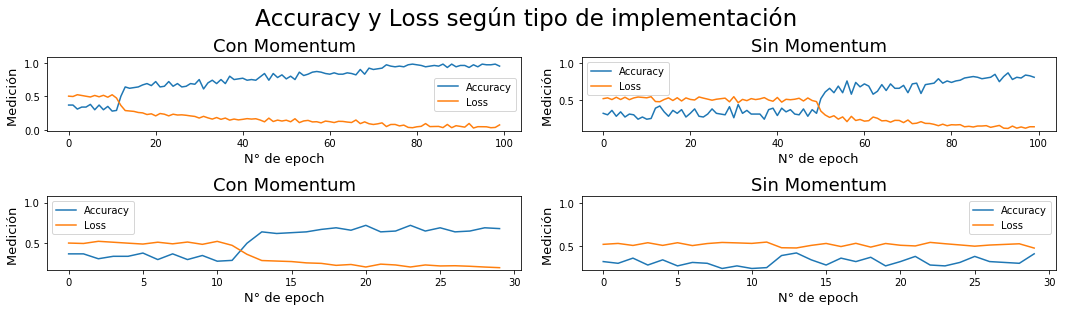



 -----------------------EPOCH #100 -------------------
Accuracy con Momentum = 95.0%
Accuracy sin Momentum = 81.0%


Loss con Momentum = 0.0745
Loss sin Momentum = 0.1373
 -----------------------EPOCH #40 -------------------
Accuracy con Momentum = 68.0%
Accuracy sin Momentum = 41.0%


Loss con Momentum = 0.2004
Loss sin Momentum = 0.4765


In [86]:
x = [max(accuracy_sc_m), max(loss_sc_m),max(accuracy_sc),max(loss_sc)]
valor_maximo = max(x)+0.1

plt.figure(1, figsize=(15,4))
plt.suptitle("Accuracy y Loss según tipo de implementación \n \n", fontsize=23, y=1.07)

plt.subplot(221)
plt.title("Con Momentum",fontsize=18)
plt.plot(range(len(accuracy_sc_m)), accuracy_sc_m, label="Accuracy")
plt.plot(range(len(loss_sc_m)), loss_sc_m, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(222)
plt.title("Sin Momentum",fontsize=18)
plt.plot(range(len(accuracy_sc)), accuracy_sc, label="Accuracy")
plt.plot(range(len(loss_sc)), loss_sc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(223)
plt.title("Con Momentum",fontsize=18)
plt.plot(range(num_epochs_minimo), accuracy_sc_m[0:num_epochs_minimo], label="Accuracy")
plt.plot(range(num_epochs_minimo), loss_sc_m[0:num_epochs_minimo], label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(224)
plt.title("Sin Momentum",fontsize=18)
plt.plot(range(num_epochs_minimo), accuracy_sc[0:num_epochs_minimo], label="Accuracy")
plt.plot(range(num_epochs_minimo), loss_sc[0:num_epochs_minimo], label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()


plt.tight_layout() 
plt.show()
print("\n")
print(" -----------------------EPOCH #100 -------------------")
print("Accuracy con Momentum = "+str(round(accuracy_sc_m[-1]*100,2))+"%")
print("Accuracy sin Momentum = "+str(round(accuracy_sc[-1]*100,2))+"%")
print("\n")
print("Loss con Momentum = "+str(round(loss_sc_m[-1],4)))
print("Loss sin Momentum = "+str(round(loss_sc[-1],4)))

print(" -----------------------EPOCH #40 -------------------")
print("Accuracy con Momentum = "+str(round(accuracy_sc_m[num_epochs_minimo-1]*100,2))+"%")
print("Accuracy sin Momentum = "+str(round(accuracy_sc[num_epochs_minimo-1]*100,2))+"%")
print("\n")
print("Loss con Momentum = "+str(round(loss_sc_m[num_epochs_minimo-1],4)))
print("Loss sin Momentum = "+str(round(loss_sc[num_epochs_minimo-1],4)))


**Notar que por columna los gráficos muestran resultados obtenidos de una misma red neuronal, se mostraron gráficos distintos para poder visualizar los resultados obtenidos en los 100 epochs totales y en los primeros 30 epochs (de manera que fuese más fácil para el lector observar los resultados)**.

Los resultados anteriores desmuestran que la red neuronal con *momentum* necesita de un menor número de iteraciones para poder alcanzar un buen nivel de *accuracy*. La diferencia es significativa, esto se debe a que el momentum  permite que la red pueda converger y alcanzar el mínimo global (no se queda atascado en mínimos locales). Además, notar que la red con *momentum* tiene una menor pérdida (*loss*) que la otra red. 



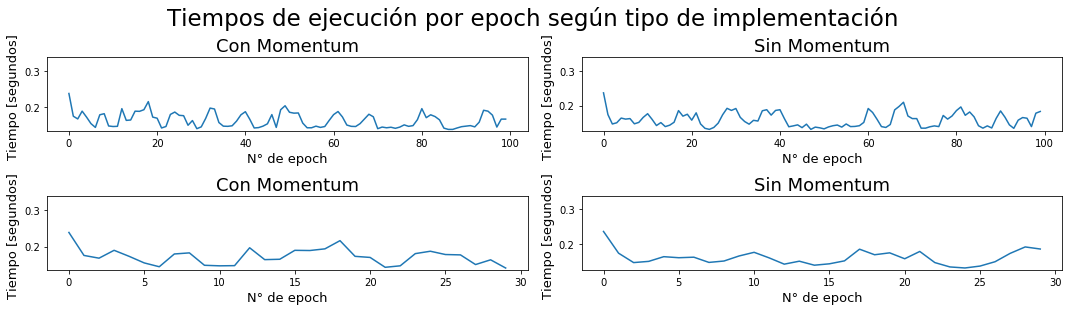

 -----------------------EPOCH #100 -------------------
Tiempo total de red con momentum: 16.49 segundos
Tiempo total de red sin momentum: 15.91 segundos


 -----------------------EPOCH #40 -------------------
Tiempo total de red con momentum hasta este epoch: 6.83 segundos
Tiempo total de red sin momentum hasta este epoch: 6.55 segundos




In [87]:
x = [max(tiempo_sc_m),max(tiempo_sc)]
valor_maximo = max(x)+0.1
plt.figure(1, figsize=(15,4))
plt.suptitle("Tiempos de ejecución por epoch según tipo de implementación \n \n", fontsize=23, y=1.07)

plt.subplot(221)
plt.title("Con Momentum",fontsize=18)
plt.plot(range(len(tiempo_sc_m)), tiempo_sc_m)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.subplot(222)
plt.title("Sin Momentum",fontsize=18)
plt.plot(range(len(tiempo_sc)), tiempo_sc)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.subplot(223)
plt.title("Con Momentum",fontsize=18)
plt.plot(range((num_epochs_minimo)), tiempo_sc_m[0:num_epochs_minimo])
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.subplot(224)
plt.title("Sin Momentum",fontsize=18)
plt.plot(range((num_epochs_minimo)), tiempo_sc[0:num_epochs_minimo])
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.tight_layout() 
plt.show()

print(" -----------------------EPOCH #100 -------------------")
print("Tiempo total de red con momentum: "+str(round(sum(tiempo_sc_m),2))+" segundos")
print("Tiempo total de red sin momentum: "+str(round(sum(tiempo_sc),2))+" segundos")
print("\n")

print(" -----------------------EPOCH #40 -------------------")
print("Tiempo total de red con momentum hasta este epoch: "+str(round(sum(tiempo_sc_m[0:40]),2))+" segundos")
print("Tiempo total de red sin momentum hasta este epoch: "+str(round(sum(tiempo_sc[0:40]),2))+" segundos")
print("\n")


Si bien durante los primeros 30 epochs pareciese que la red con *momentum* tiende a disminuir el tiempo que requiere por cada iteración, una visualización de los 100 epochs da cuenta de que esto no es así y que tanto para la red con *momentum* como la red que no posee esta característica presentan una gran variación del tiempo requerido entre sus epochs. 

El tiempo que requieren ambas redes es bastante similar, por lo que en caso de tener que decidir por un algoritmo eficiente y eficaz se debería optar por una red neuronal que utilice *momentum*.

Por último, hay que mencionar que con los resultados obtenidos es claro que la red con *momentum* es una herramienta útil para resolver un problema de clasificación. ¡Funciona!


### Redes Con Momentum - Implementación propia vs Keras

Adicionalmente se realizó una comparación entre una red implementada por nosotros y una red implementada por Keras. Ambas utilizan *momentum*, los resultados fueron los siguientes:



In [88]:
tiempos_keras_sc = TimingCallback()
num_epochs = 100
num_epochs_minimo = 40

#### Implementación propia con Momentum 

In [89]:
nn_sc_m = RedNeuronal(4, [32,16], 3, "sigmoid", "crossentropy")
nn_sc_m.train(x_train, y_onehot_train, num_epochs, 0.1, momentum=0.8)
loss_sc_m = nn_sc_m.log['loss']
accuracy_sc_m = nn_sc_m.log['accuracy']
tiempo_sc_m = nn_sc_m.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Comienza entrenamiento de red con momentum 0.8
Resultado de training set de 100 epochs: loss 0.0223870421566 - acc: 0.99


#### Keras con Momentum

In [90]:
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(3, activation="softmax"))

model.compile(optimizer=SGD(lr=0.1,  momentum=0.8),loss="categorical_crossentropy", metrics=["accuracy"])

#Entrenamiento de red utilizando keras. Función activación:  sigmoide  Función de costo: cross entropy
tiempos_keras_sc_m = TimingCallback()
keras_sc_m = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=0, callbacks=[tiempos_keras_sc_m])
accuracy_keras_sc_m = keras_sc.history['acc']
loss_keras_sc_m = keras_sc.history['loss']

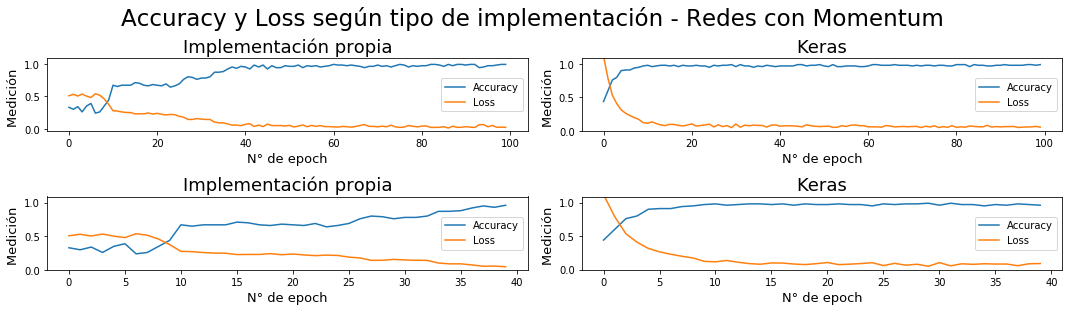



 -----------------------EPOCH #100 -------------------
Accuracy con Implementación propia = 99.0%
Accuracy con Keras = 99.0%


Loss con Implementación propia = 0.0224
Loss con Keras= 0.0583


 -----------------------EPOCH #40 -------------------
Accuracy con Implementación propia = 96.0%
Accuracy con Keras = 96.0%


Loss con Implementación propia = 0.0486
Loss con Keras = 0.4843


In [91]:
x = [max(accuracy_sc_m), max(loss_sc_m),max(accuracy_sc),max(loss_sc)]
valor_maximo = max(x)+0.1

plt.figure(1, figsize=(15,4))
plt.suptitle("Accuracy y Loss según tipo de implementación - Redes con Momentum \n \n", fontsize=23, y=1.07)

plt.subplot(221)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(accuracy_sc_m)), accuracy_sc_m, label="Accuracy")
plt.plot(range(len(loss_sc_m)), loss_sc_m, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(222)
plt.title("Keras",fontsize=18)
plt.plot(range(len(accuracy_keras_sc_m)), accuracy_keras_sc_m, label="Accuracy")
plt.plot(range(len(loss_keras_sc_m)), loss_keras_sc_m, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(223)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(num_epochs_minimo), accuracy_sc_m[0:num_epochs_minimo], label="Accuracy")
plt.plot(range(num_epochs_minimo), loss_sc_m[0:num_epochs_minimo], label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(224)
plt.title("Keras",fontsize=18)
plt.plot(range(num_epochs_minimo), accuracy_keras_sc_m[0:num_epochs_minimo], label="Accuracy")
plt.plot(range(num_epochs_minimo), loss_keras_sc_m[0:num_epochs_minimo], label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()


plt.tight_layout() 
plt.show()
print("\n")
print(" -----------------------EPOCH #100 -------------------")
print("Accuracy con Implementación propia = "+str(round(accuracy_sc_m[-1]*100,2))+"%")
print("Accuracy con Keras = "+str(round(accuracy_keras_sc_m[-1]*100,2))+"%")
print("\n")
print("Loss con Implementación propia = "+str(round(loss_sc_m[-1],4)))
print("Loss con Keras= "+str(round(loss_keras_sc_m[-1],4)))
print("\n")
print(" -----------------------EPOCH #40 -------------------")
print("Accuracy con Implementación propia = "+str(round(accuracy_sc_m[num_epochs_minimo-1]*100,2))+"%")
print("Accuracy con Keras = "+str(round(accuracy_keras_sc_m[num_epochs_minimo-1]*100,2))+"%")
print("\n")
print("Loss con Implementación propia = "+str(round(loss_sc_m[num_epochs_minimo-1],4)))
print("Loss con Keras = "+str(round(loss_sc[num_epochs_minimo-1],4)))


**Notar que por columna los gráficos muestran resultados obtenidos de una misma red neuronal, se mostrarón gráficos distintos para poder mostrar los resultados obtenidos en los 100 epochs totales y en los primeros 40 epochs (de manera que fuese más fácil para el lector observar los resultados)**.

Los resultados anteriores muestran que la red neuronal con momentum implementada por Keras entrega resultados similares a los obtenidos por la implementación propia. Si bien, en el epoch #100 ambas implementaciones entregan un *accuracy* del 99%, la implementación de Keras converge mucho más rapido y alcanza este resultado en un menor número de iteraciones. 

Sorprendente la pérdida es menor en la implementación propia. 



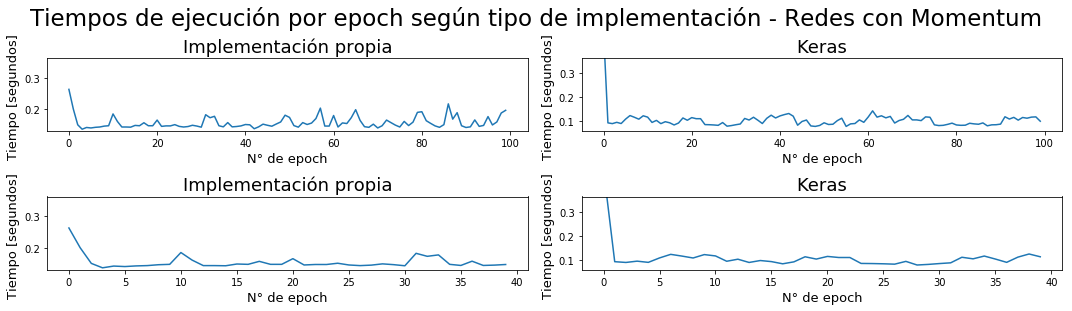

 -----------------------EPOCH #100 -------------------
Tiempo total - Implementación propia : 15.78 segundos
Tiempo total - Keras: 10.53 segundos


 -----------------------EPOCH #40 -------------------
Tiempo total hasta este epoch - Implementación propia: 6.19 segundos
Tiempo total hasta este epoch - Keras: 4.42 segundos




In [92]:
x = [max(tiempo_sc_m),max(tiempo_sc)]
valor_maximo = max(x)+0.1
plt.figure(1, figsize=(15,4))
plt.suptitle("Tiempos de ejecución por epoch según tipo de implementación - Redes con Momentum\n \n", fontsize=23, y=1.07)

plt.subplot(221)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(tiempo_sc_m)), tiempo_sc_m)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.subplot(222)
plt.title("Keras",fontsize=18)
plt.plot(range(len(tiempo_sc_m)), tiempos_keras_sc_m.logs)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.subplot(223)
plt.title("Implementación propia",fontsize=18)
plt.plot(range((num_epochs_minimo)), tiempo_sc_m[0:num_epochs_minimo])
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.subplot(224)
plt.title("Keras",fontsize=18)
plt.plot(range((num_epochs_minimo)), tiempos_keras_sc_m.logs[0:num_epochs_minimo])
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)

plt.tight_layout() 
plt.show()

print(" -----------------------EPOCH #100 -------------------")
print("Tiempo total - Implementación propia : "+str(round(sum(tiempo_sc_m),2))+" segundos")
print("Tiempo total - Keras: "+str(round(sum(tiempos_keras_sc_m.logs),2))+" segundos")
print("\n")

print(" -----------------------EPOCH #40 -------------------")
print("Tiempo total hasta este epoch - Implementación propia: "+str(round(sum(tiempo_sc_m[0:40]),2))+" segundos")
print("Tiempo total hasta este epoch - Keras: "+str(round(sum(tiempos_keras_sc_m.logs[0:40]),2))+" segundos")
print("\n")


Además, los resultados también muestran que el algoritmo con momentum de keras es mucho más eficiente que el algoritmo propio. El algoritmo propio es un tercio más lento que el diseñado por Keras. Además, en el algoritmo de Keras los tiempos por epoch disminuyen significativamente en las primeras iteraciones y luego muestra una estabilidad, demorandosé aproximadamente lo mismo por epoch. En cambio, el algoritmo propio varía constantemente su tiempo de ejecución por epoch, no hay una estabilidad.





## Distintos valores de momentum

Por último, se utilizaron distintos valores de momentum para descubrir cual es el que entrega mejores resultados para este problema. Los resultados fueron los siguientes:



In [100]:
num_epochs_momentum = 30

In [101]:
nn_sc_m_1 = RedNeuronal(4, [32,16], 3, "sigmoid", "crossentropy")
nn_sc_m_1.train(x_train, y_onehot_train, 30 , 0.1, momentum=1)
loss_sc_m_1 = nn_sc_m_1.log['loss']
accuracy_sc_m_1 = nn_sc_m_1.log['accuracy']
tiempo_sc_m_1 = nn_sc_m_1.log['tiempo']

nn_sc_m_09 = RedNeuronal(4, [32,16], 3, "sigmoid", "crossentropy")
nn_sc_m_09.train(x_train, y_onehot_train, 30 , 0.1, momentum=0.9)
loss_sc_m_09 = nn_sc_m_09.log['loss']
accuracy_sc_m_09 = nn_sc_m_09.log['accuracy']
tiempo_sc_m_09 = nn_sc_m_09.log['tiempo']

nn_sc_m_08 = RedNeuronal(4, [32,16], 3, "sigmoid", "crossentropy")
nn_sc_m_08.train(x_train, y_onehot_train, 30 , 0.1, momentum=0.8)
loss_sc_m_08 = nn_sc_m_08.log['loss']
accuracy_sc_m_08 = nn_sc_m_08.log['accuracy']
tiempo_sc_m_08 = nn_sc_m_08.log['tiempo']

nn_sc_m_07 = RedNeuronal(4, [32,16], 3, "sigmoid", "crossentropy")
nn_sc_m_07.train(x_train, y_onehot_train, 30 , 0.1, momentum=0.7)
loss_sc_m_07 = nn_sc_m_07.log['loss']
accuracy_sc_m_07 = nn_sc_m_07.log['accuracy']
tiempo_sc_m_07 = nn_sc_m_07.log['tiempo']

nn_sc_m_06 = RedNeuronal(4, [32,16], 3, "sigmoid", "crossentropy")
nn_sc_m_06.train(x_train, y_onehot_train, 30 , 0.1, momentum=0.6)
loss_sc_m_06 = nn_sc_m_06.log['loss']
accuracy_sc_m_06 = nn_sc_m_06.log['accuracy']
tiempo_sc_m_06 = nn_sc_m_06.log['tiempo']

nn_sc_m_05 = RedNeuronal(4, [32,16], 3, "sigmoid", "crossentropy")
nn_sc_m_05.train(x_train, y_onehot_train, 30 , 0.1, momentum=0.5)
loss_sc_m_05 = nn_sc_m_05.log['loss']
accuracy_sc_m_05 = nn_sc_m_05.log['accuracy']
tiempo_sc_m_05 = nn_sc_m_05.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Comienza entrenamiento de red con momentum 1
Resultado de training set de 30 epochs: loss 0.468732569698 - acc: 0.3
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Comienza entrenamiento de red con momentum 0.9
Resultado de training set de 30 epochs: loss 0.11164187472 - acc: 0.84
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Comienza entrenamiento de red con momentum 0.8
Resultado de training set de 30 epochs: loss 0.389390185064 - acc: 0.46
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Comienza entrenamiento de red con momentum 0.7
Resultado de training set de 30 epochs: loss 0.248482207545 - acc: 0.66
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Comienza entrenami

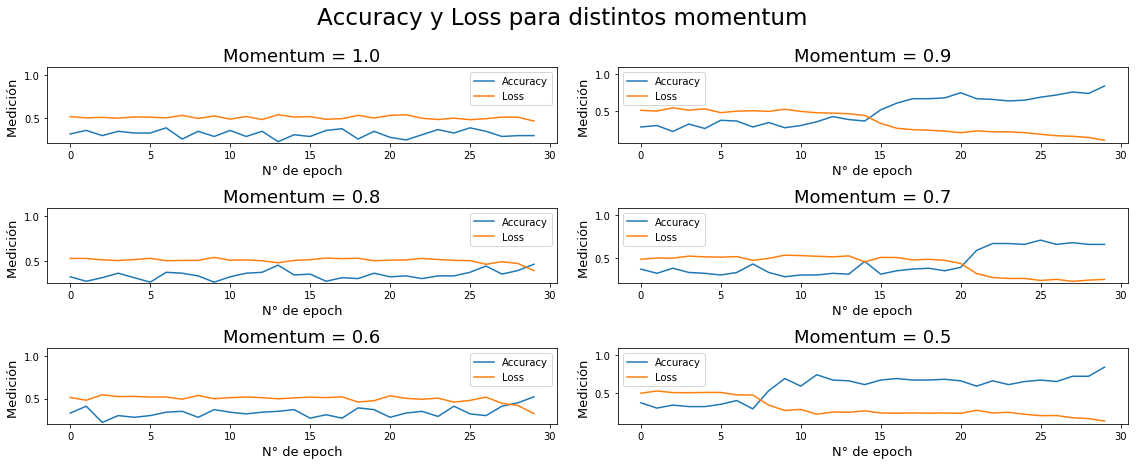



 -----------------------Momentum = 1.0  -------------------
Accuracy con Momentum = 1.0: 30.0%
Loss con Momentum = 1.0: 0.4687


 -----------------------Momentum = 0.9  -------------------
Accuracy con Momentum = 0.9: 84.0%
Loss con Momentum = 0.9: 0.1116


 -----------------------Momentum = 0.8  -------------------
Accuracy con Momentum = 0.8: 46.0%
Loss con Momentum = 0.8: 0.3894


 -----------------------Momentum = 0.7  -------------------
Accuracy con Momentum = 0.7: 66.0%
Loss con Momentum = 0.7: 0.2485


 -----------------------Momentum = 0.6  -------------------
Accuracy con Momentum = 0.6: 52.0%
Loss con Momentum = 0.6: 0.3231


 -----------------------Momentum = 0.5  -------------------
Accuracy con Momentum = 0.5: 84.0%
Loss con Momentum = 0.5: 0.1287




In [105]:
x = [max(accuracy_sc_m), max(loss_sc_m),max(accuracy_sc),max(loss_sc)]
valor_maximo = max(x)+0.1

plt.figure(1, figsize=(16,6))
plt.suptitle("Accuracy y Loss para distintos momentum \n \n", fontsize=23, y=1.07)

plt.subplot(321)
plt.title("Momentum = 1.0",fontsize=18)
plt.plot(range(len(accuracy_sc_m_1)), accuracy_sc_m_1, label="Accuracy")
plt.plot(range(len(loss_sc_m_1)), loss_sc_m_1, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(322)
plt.title("Momentum = 0.9",fontsize=18)
plt.plot(range(len(accuracy_sc_m_09)), accuracy_sc_m_09, label="Accuracy")
plt.plot(range(len(loss_sc_m_09)), loss_sc_m_09, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(323)
plt.title("Momentum = 0.8",fontsize=18)
plt.plot(range(len(accuracy_sc_m_08)), accuracy_sc_m_08, label="Accuracy")
plt.plot(range(len(loss_sc_m_08)), loss_sc_m_08, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(324)
plt.title("Momentum = 0.7",fontsize=18)
plt.plot(range(len(accuracy_sc_m_07)), accuracy_sc_m_07, label="Accuracy")
plt.plot(range(len(loss_sc_m_07)), loss_sc_m_07, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(325)
plt.title("Momentum = 0.6",fontsize=18)
plt.plot(range(len(accuracy_sc_m_06)), accuracy_sc_m_06, label="Accuracy")
plt.plot(range(len(loss_sc_m_06)), loss_sc_m_06, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.subplot(326)
plt.title("Momentum = 0.5",fontsize=18)
plt.plot(range(len(accuracy_sc_m_05)), accuracy_sc_m_05, label="Accuracy")
plt.plot(range(len(loss_sc_m_05)), loss_sc_m_05, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.ylim(ymax=valor_maximo)
plt.legend()

plt.tight_layout() 
plt.show()
print("\n")
print(" -----------------------Momentum = 1.0  -------------------")
print("Accuracy con Momentum = 1.0: "+str(round(accuracy_sc_m_1[num_epochs_momentum-1]*100,2))+"%")
print("Loss con Momentum = 1.0: "+str(round(loss_sc_m_1[num_epochs_momentum-1],4)))
print("\n")
print(" -----------------------Momentum = 0.9  -------------------")
print("Accuracy con Momentum = 0.9: "+str(round(accuracy_sc_m_09[num_epochs_momentum-1]*100,2))+"%")
print("Loss con Momentum = 0.9: "+str(round(loss_sc_m_09[num_epochs_momentum-1],4)))
print("\n")
print(" -----------------------Momentum = 0.8  -------------------")
print("Accuracy con Momentum = 0.8: "+str(round(accuracy_sc_m_08[num_epochs_momentum-1]*100,2))+"%")
print("Loss con Momentum = 0.8: "+str(round(loss_sc_m_08[num_epochs_momentum-1],4)))
print("\n")
print(" -----------------------Momentum = 0.7  -------------------")
print("Accuracy con Momentum = 0.7: "+str(round(accuracy_sc_m_07[num_epochs_momentum-1]*100,2))+"%")
print("Loss con Momentum = 0.7: "+str(round(loss_sc_m_07[num_epochs_momentum-1],4)))
print("\n")
print(" -----------------------Momentum = 0.6  -------------------")
print("Accuracy con Momentum = 0.6: "+str(round(accuracy_sc_m_06[num_epochs_momentum-1]*100,2))+"%")
print("Loss con Momentum = 0.6: "+str(round(loss_sc_m_06[num_epochs_momentum-1],4)))
print("\n")
print(" -----------------------Momentum = 0.5  -------------------")
print("Accuracy con Momentum = 0.5: "+str(round(accuracy_sc_m_05[num_epochs_momentum-1]*100,2))+"%")
print("Loss con Momentum = 0.5: "+str(round(loss_sc_m_05[num_epochs_momentum-1],4)))
print("\n")

Para este caso en particular, los mejores resultados se obtuvieron para las redes con *momentum* = 0.9 y *momentum* = 0.5 . En ambos casos se alcanzó un *accuracy* de 84%. 

El peor resultado se obtuvo con momentum = 1.0. Recordar que un alto valor de *momentum* ocasionará que el algoritmo se salte el mínimo global a pasos agigantados. 


No existe una regla sencilla para determinar cual es el valor adecuado de *momentum* para cada caso, por lo que escoger el valor de esta variable a prueba y error es una opción completamente válida. 







## Referencias

* Momentum: https://www.willamette.edu/~gorr/classes/cs449/momrate.html
* Momentum: https://distill.pub/2017/momentum/
* Fórmula Momentum: https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx